### Single-objective and Multi-objective Bayesian optimization for a retention modelling toy example

In this tutorial, we illustrate how to implement the single-objective and multi-objective BO algorithms. It closely follows the toy retention modelling experiment shown in Section 4.5 of [Closed-loop automatic gradient design for liquid chromatography using Bayesian optimization](https://chemrxiv.org/engage/chemrxiv/article-details/62e2a383e7fc8f9e388caabc).

In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt

import torch

try:
    from botorch.sampling.samplers import SobolQMCNormalSampler
except:
    from botorch.sampling.normal import SobolQMCNormalSampler
    
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel, SpectralMixtureKernel, PolynomialKernel, LinearKernel
from gpytorch.priors import GammaPrior

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, NoisyExpectedImprovement, qNoisyExpectedImprovement

from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement

from bo_code.MaternSortKernel import MaternSortKernel
from bo_code.BO import BO_round, MOBO_round

from rm_code.crf import crf, capped_sum_of_resolutions, sort_peaks
from rm_code.retention_model import retention_time_multisegment_gradient, compute_chromatogram
import rm_code.read_data as rd
import rm_code.chromatographic_response_functions as of
from rm_code.plot_chromatogram import plot_chromatogram

from utils.utils import seed_everything, generate_initial_sorted_data, bo_to_rm, best_so_far, hv, ci

/Users/jimboelrijk/opt/anaconda3/envs/github_test/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load some retention parameters (for Linear Solvent Strength model)
ret_pars = np.loadtxt('data/RetentionParams_Section4.5.txt') # retention parameters from example in Section 4.5

k0_list = np.exp(ret_pars[:,0])
S_list = ret_pars[:,1]

In [3]:
# Set some default parameters
t_0 = 0.8 # dead time 
t_D = 0.8 # dwell time
N = 1000 # plate number
t_init = 0 # init time

In [4]:
# Let's try out a linear gradient
phi_list_lin = [0, 0.5, 1] # phi values
t_list_lin = [0, 30, 60] # time values
# compute retention times and peak widths
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_lin, t_list_lin, N)

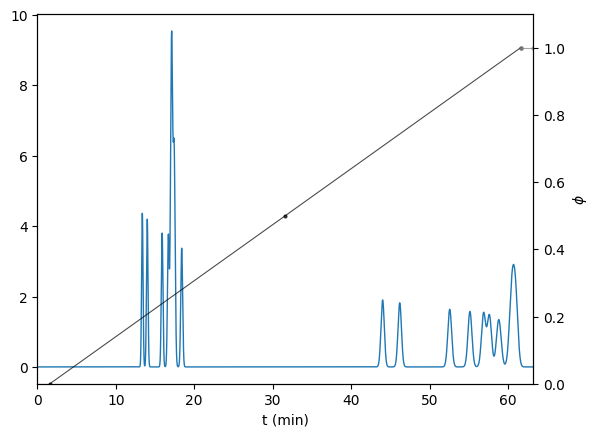

In [5]:
# plot chromatogram
plot_chromatogram(tR_list, W_list, phi_list_lin, t_list_lin, t_D, t_0, t_init)

In [6]:
# compute score of measurement (eq 6. in paper)
score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
# compute time score, i.e. time of last eluting peak.
time_score_lin = np.max(tR_list)
print(score_lin, time_score_lin)

12.098972668422277 61.0081858678997


# Let's try and find a handpicked gradient program, this will serve as a nice baseline for the Bayesian optimization algorithm

In [7]:
phi_list_ms = [0,0.18, 0.25,0.8, 1, 1]
t_list_ms = [0,0.1, 13,13.1, 30,60]
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_ms, t_list_ms, N)

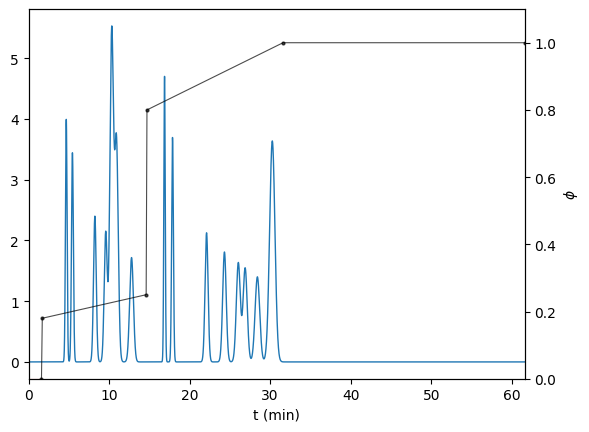

In [8]:
plot_chromatogram(tR_list, W_list, phi_list_ms, t_list_ms, t_D, t_0, t_init)

In [9]:
# compute scores 
score_ms = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
# compute time score, i.e. time of last eluting peak.
time_score_ms = np.max(tR_list)
print(score_ms, time_score_ms)

12.730314412317586 30.402499679605615


### Using the retention model, and score functions demonstrated above, we will now implement a Bayesian Optimization loop for the single-objective case.

Trial  0
INITIAL MEASUREMENT  0  RES SCORE  8.096540311807626 TIME SCORE 66.63039470412889 TOT SCORE 8.095874007860585


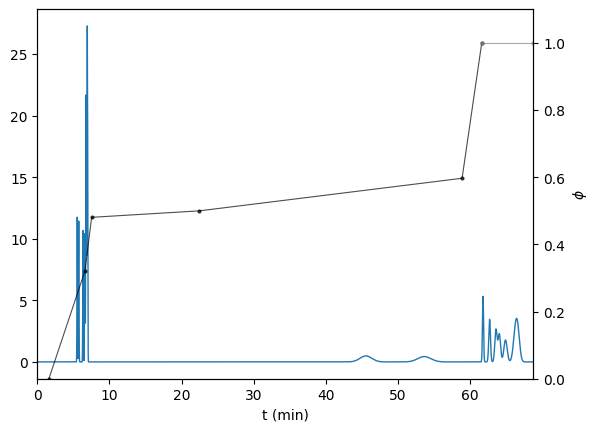

INITIAL MEASUREMENT  1  RES SCORE  12.244447653367132 TIME SCORE 60.52055116590354 TOT SCORE 12.243842447855473


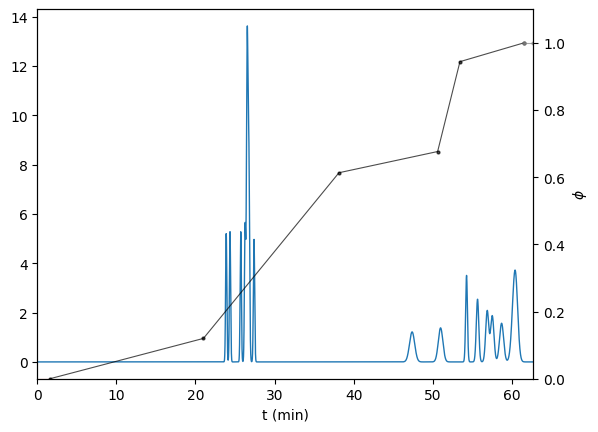

INITIAL MEASUREMENT  2  RES SCORE  12.261520725284369 TIME SCORE 56.357741284874045 TOT SCORE 12.260957147871519


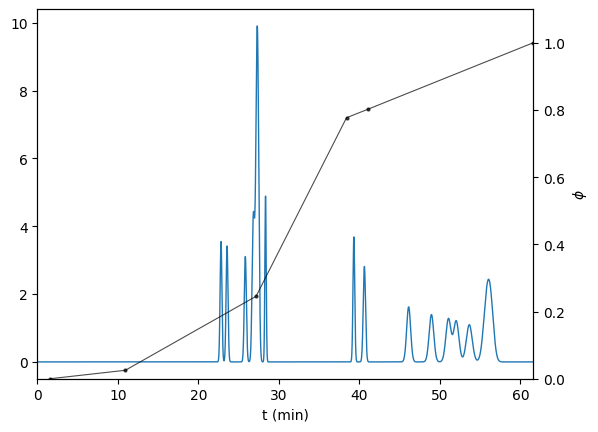

INITIAL MEASUREMENT  3  RES SCORE  8.841344664401719 TIME SCORE 64.31923442772293 TOT SCORE 8.840701472057441


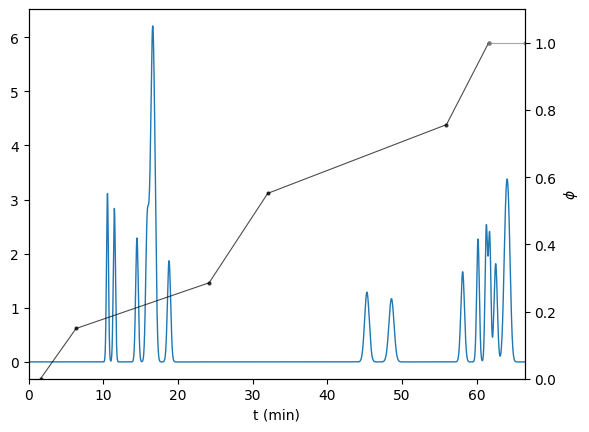

INITIAL MEASUREMENT  4  RES SCORE  12.532866437992698 TIME SCORE 36.393058196139776 TOT SCORE 12.532502507410737


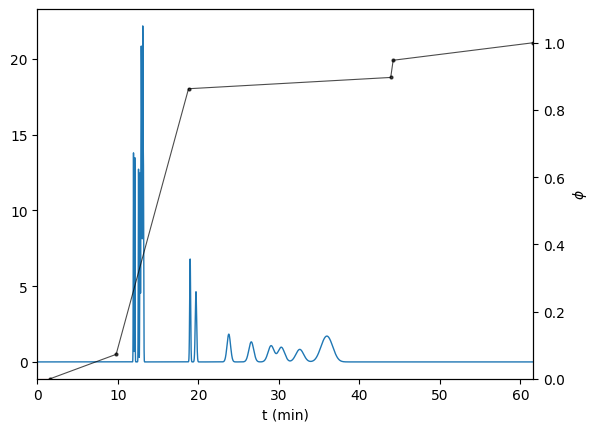

INITIAL MEASUREMENT  5  RES SCORE  10.338325756113619 TIME SCORE 63.447147176481096 TOT SCORE 10.337691284641854


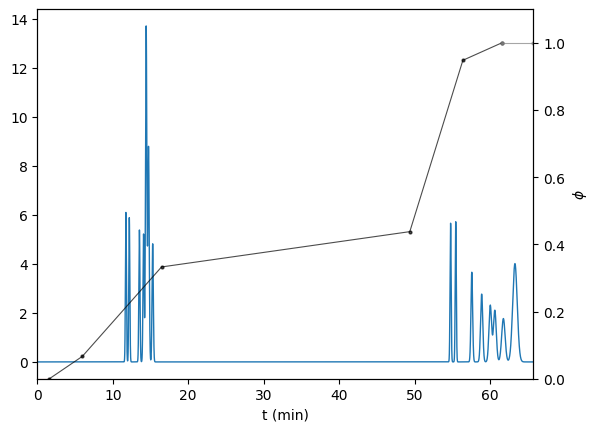

INITIAL MEASUREMENT  6  RES SCORE  12.672044432760591 TIME SCORE 54.92420637974644 TOT SCORE 12.671495190696794


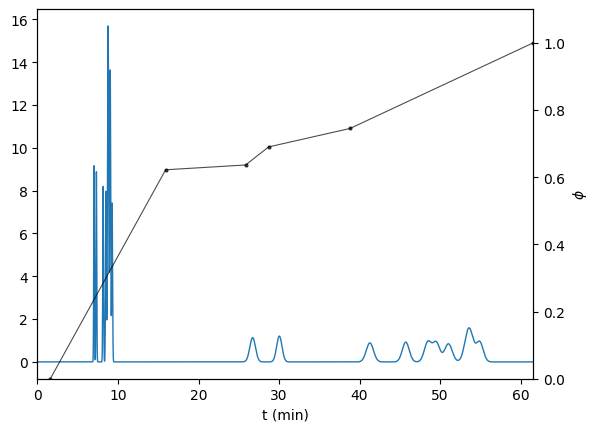

INITIAL MEASUREMENT  7  RES SCORE  5.557399428508089 TIME SCORE 69.32178955521617 TOT SCORE 5.5567062106125364


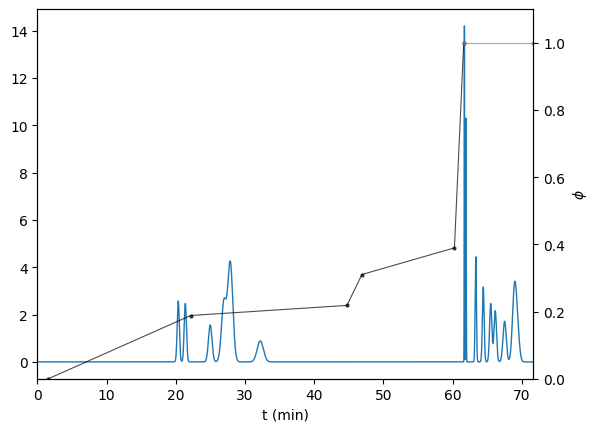

INITIAL MEASUREMENT  8  RES SCORE  12.722960236557503 TIME SCORE 53.21481517994945 TOT SCORE 12.722428088405703


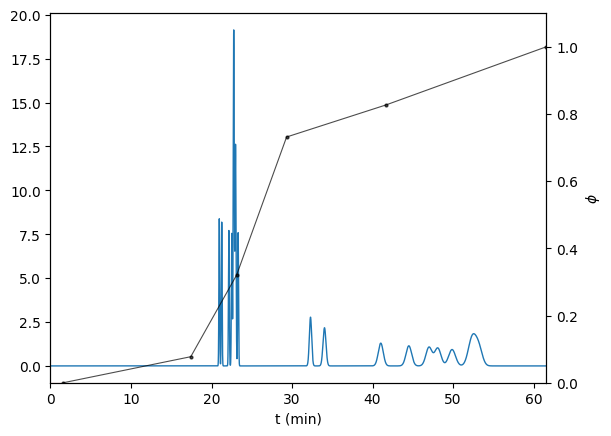

INITIAL MEASUREMENT  9  RES SCORE  10.119821344453445 TIME SCORE 63.66499675277798 TOT SCORE 10.119184694485918


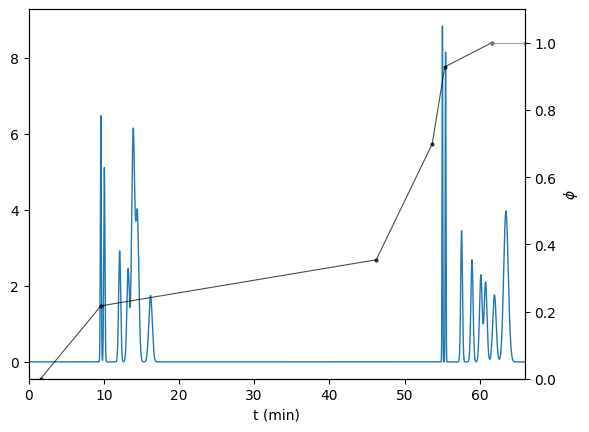

MEASUREMENT SO  0  RES SCORE  12.396144324831884 TIME SCORE 49.21091999247413 TOT SCORE 12.396144324831884


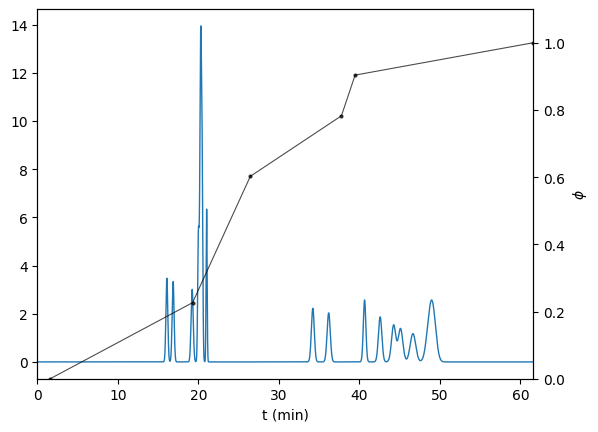

MEASUREMENT SO  1  RES SCORE  8.360702166921286 TIME SCORE 49.76673575926095 TOT SCORE 8.360702166921286


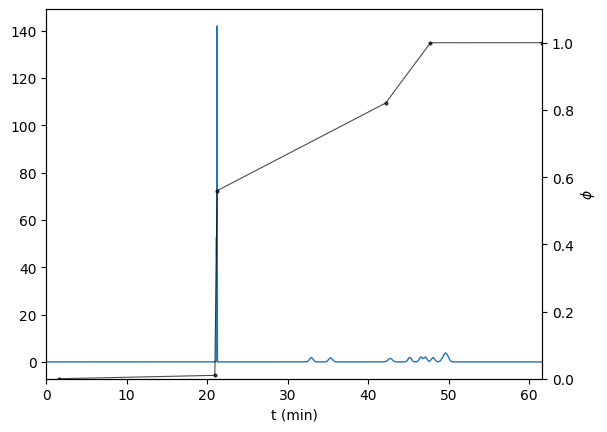

MEASUREMENT SO  2  RES SCORE  12.790925372207973 TIME SCORE 53.292508152839666 TOT SCORE 12.790925372207973


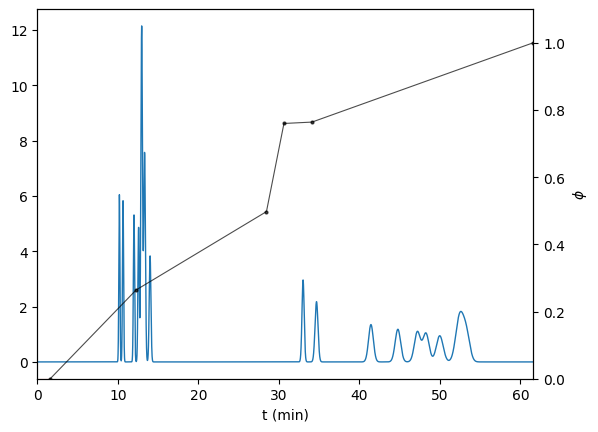

MEASUREMENT SO  3  RES SCORE  12.777156773839955 TIME SCORE 50.59684228752174 TOT SCORE 12.777156773839955


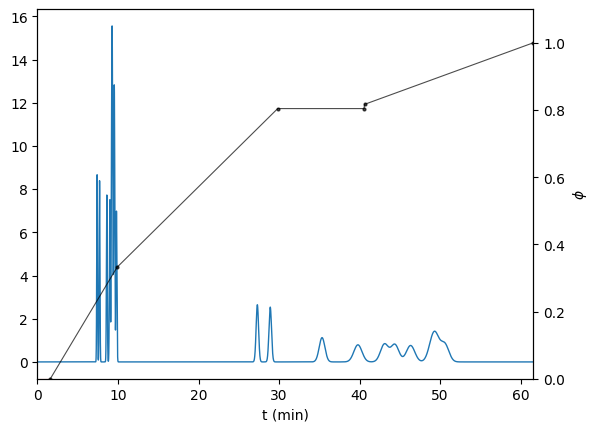

MEASUREMENT SO  4  RES SCORE  12.559796026980266 TIME SCORE 54.92078097807819 TOT SCORE 12.559796026980266


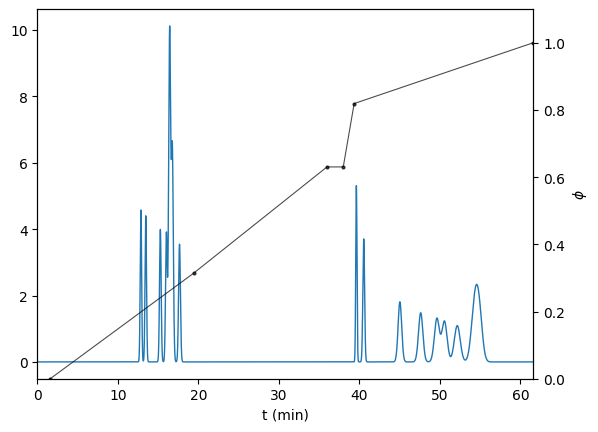

MEASUREMENT SO  5  RES SCORE  12.782626052695147 TIME SCORE 48.562596803262565 TOT SCORE 12.782626052695147


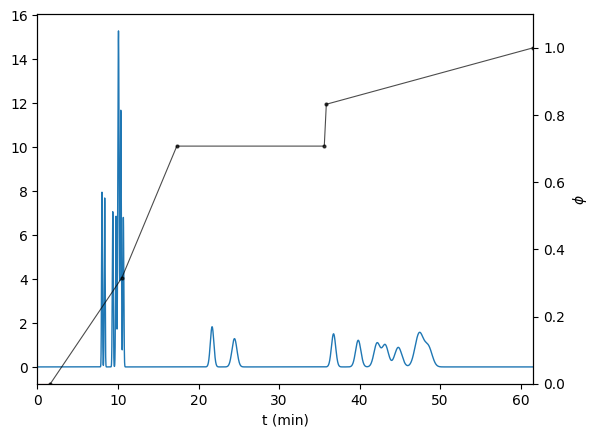

MEASUREMENT SO  6  RES SCORE  12.689323261567877 TIME SCORE 54.940797693861 TOT SCORE 12.689323261567877


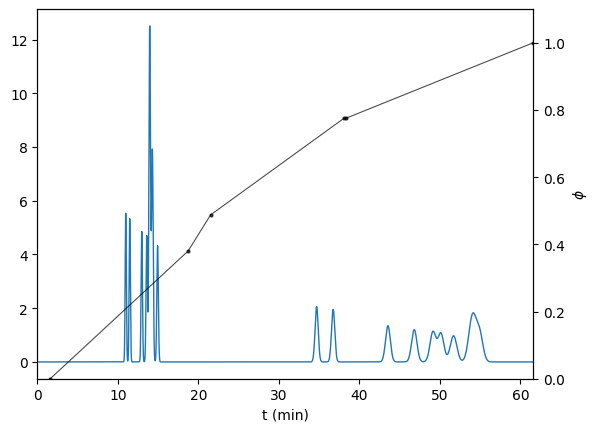

MEASUREMENT SO  7  RES SCORE  12.63084036200767 TIME SCORE 50.99494230321768 TOT SCORE 12.63084036200767


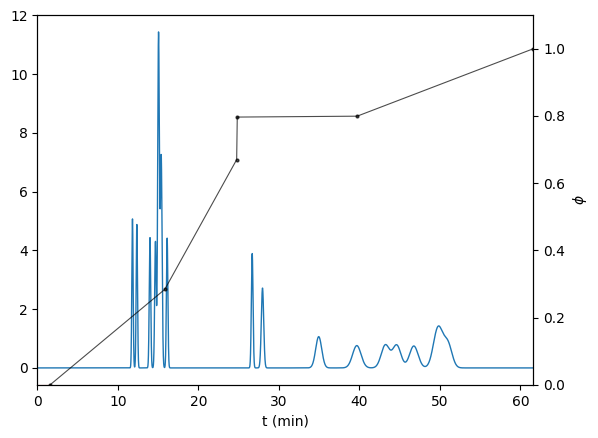

MEASUREMENT SO  8  RES SCORE  12.800661634817443 TIME SCORE 49.31091245519897 TOT SCORE 12.800661634817443


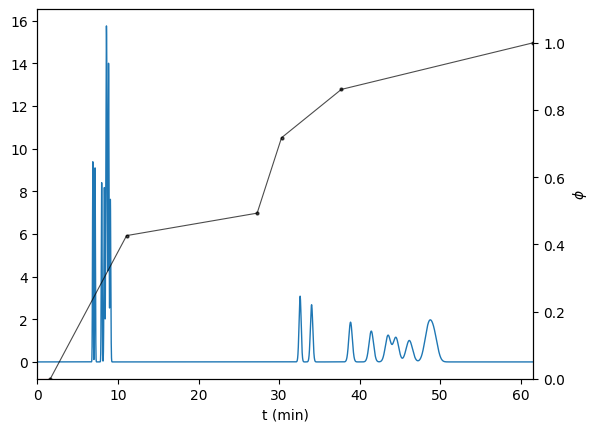

MEASUREMENT SO  9  RES SCORE  12.522017143068194 TIME SCORE 52.802181485116826 TOT SCORE 12.522017143068194


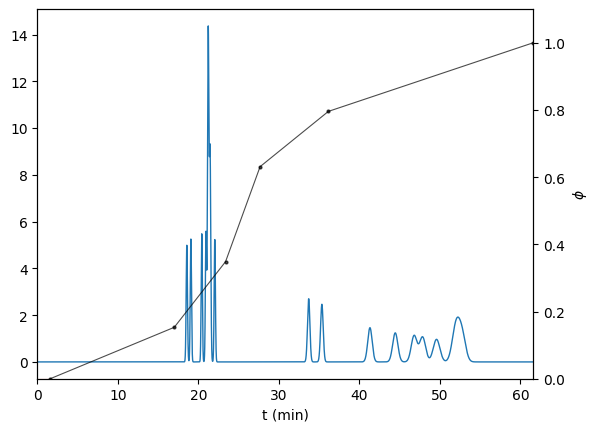

MEASUREMENT SO  10  RES SCORE  12.772525217962054 TIME SCORE 49.08739645770538 TOT SCORE 12.772525217962054


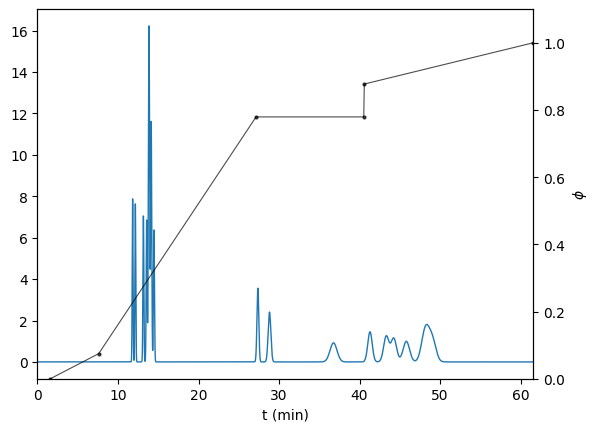

MEASUREMENT SO  11  RES SCORE  12.809471426001448 TIME SCORE 34.45853265696165 TOT SCORE 12.809471426001448


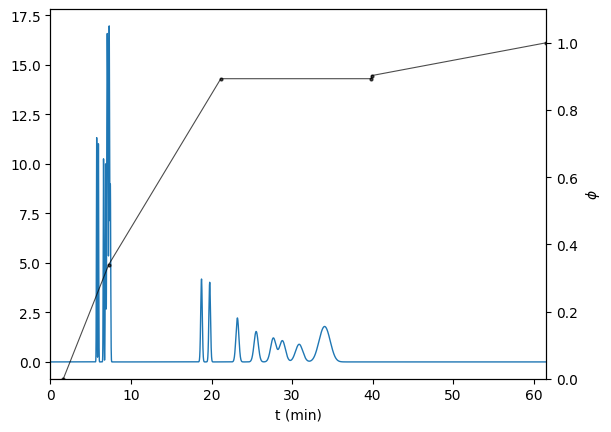

MEASUREMENT SO  12  RES SCORE  12.617251515631207 TIME SCORE 52.36697256820696 TOT SCORE 12.617251515631207


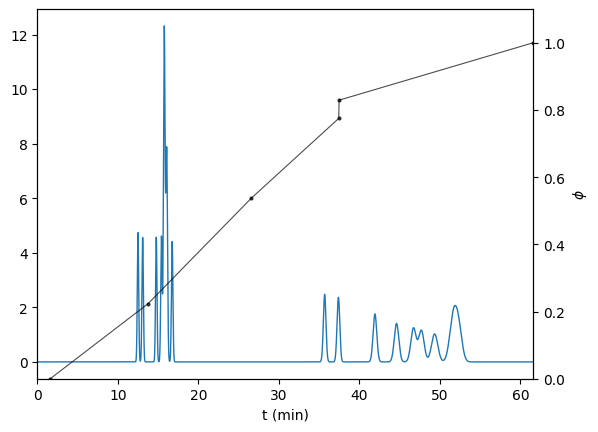

MEASUREMENT SO  13  RES SCORE  12.533984289402802 TIME SCORE 50.879518408892004 TOT SCORE 12.533984289402802


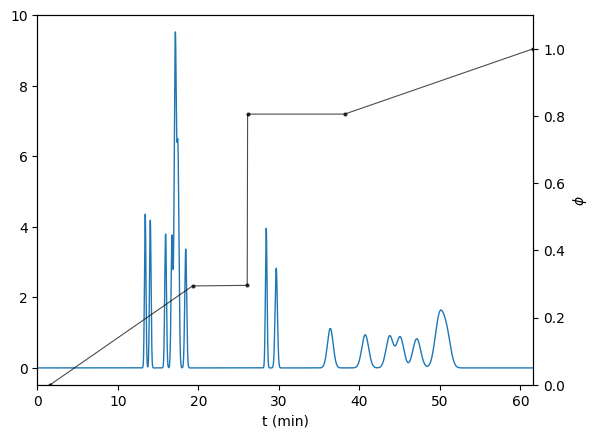

MEASUREMENT SO  14  RES SCORE  12.504005056626818 TIME SCORE 57.79785282768452 TOT SCORE 12.504005056626818


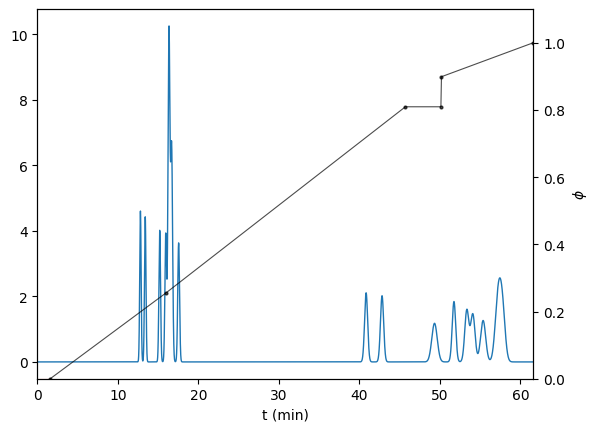

MEASUREMENT SO  15  RES SCORE  12.471301097639412 TIME SCORE 52.49791359352654 TOT SCORE 12.471301097639412


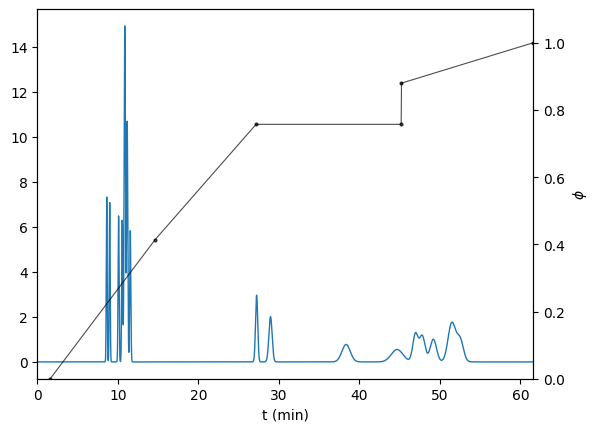

MEASUREMENT SO  16  RES SCORE  12.858731467840812 TIME SCORE 46.86121593152797 TOT SCORE 12.858731467840812


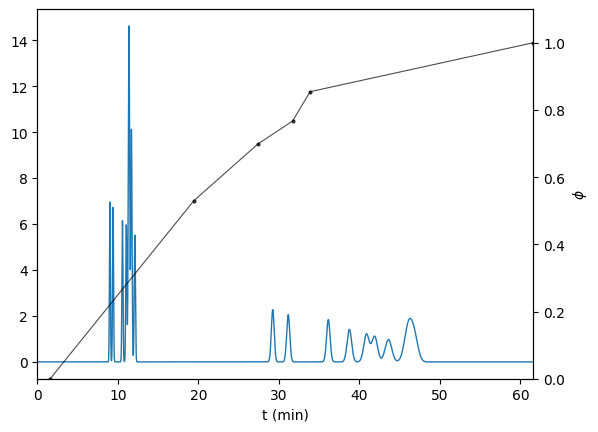

MEASUREMENT SO  17  RES SCORE  12.783827877771746 TIME SCORE 43.74226160736597 TOT SCORE 12.783827877771746


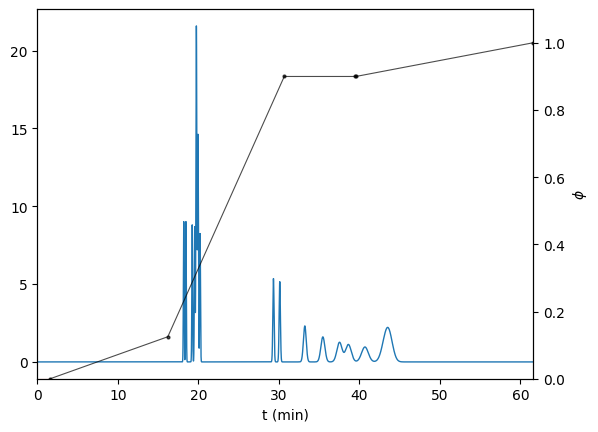

MEASUREMENT SO  18  RES SCORE  12.776735591022282 TIME SCORE 45.84175796162076 TOT SCORE 12.776735591022282


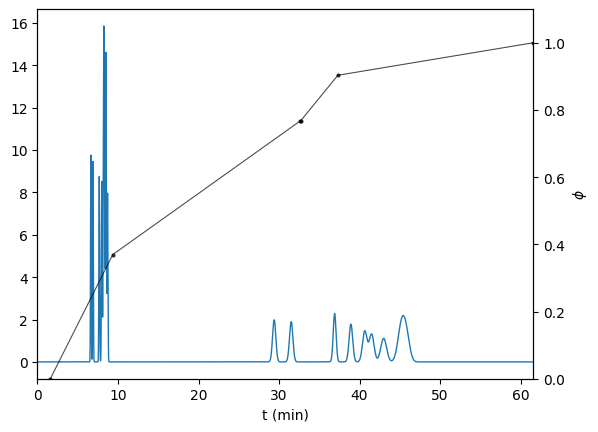

MEASUREMENT SO  19  RES SCORE  12.590745446327574 TIME SCORE 47.40759249709738 TOT SCORE 12.590745446327574


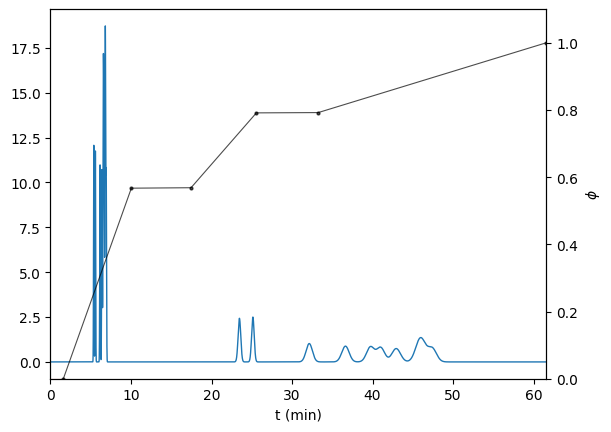

MEASUREMENT SO  20  RES SCORE  12.933577255675454 TIME SCORE 39.61628025149549 TOT SCORE 12.933577255675454


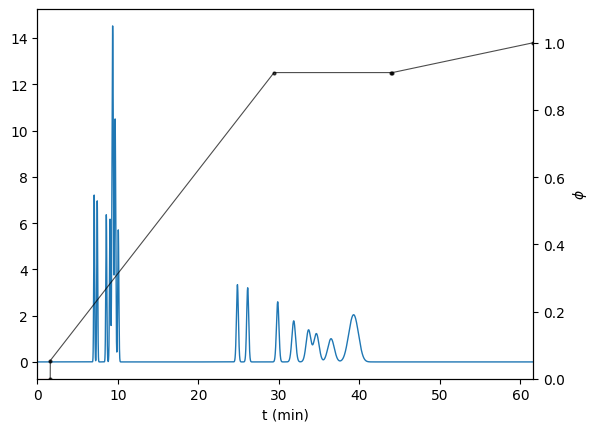

MEASUREMENT SO  21  RES SCORE  12.774054201226928 TIME SCORE 40.22663781253824 TOT SCORE 12.774054201226928


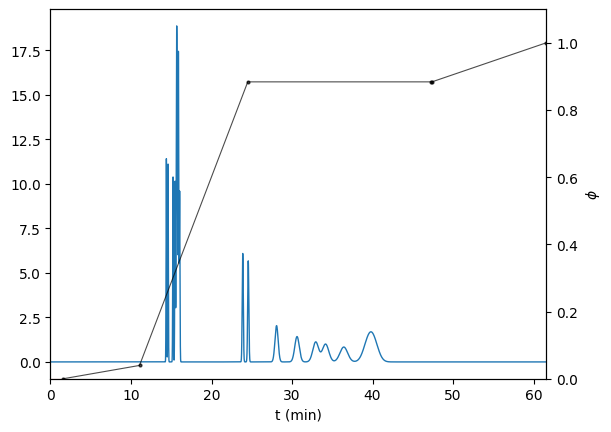

MEASUREMENT SO  22  RES SCORE  12.59071936150346 TIME SCORE 49.54928665972784 TOT SCORE 12.59071936150346


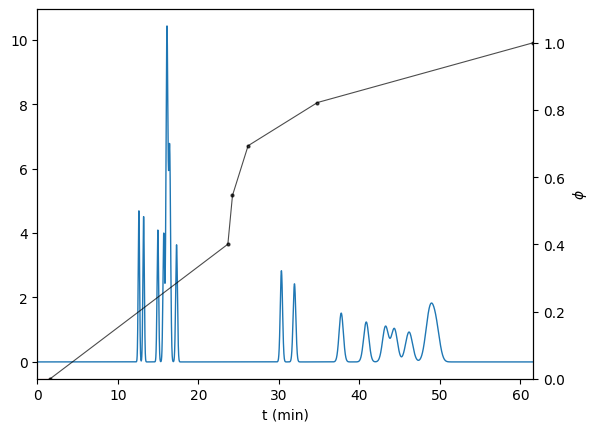

MEASUREMENT SO  23  RES SCORE  12.615709527221824 TIME SCORE 49.59714181585384 TOT SCORE 12.615709527221824


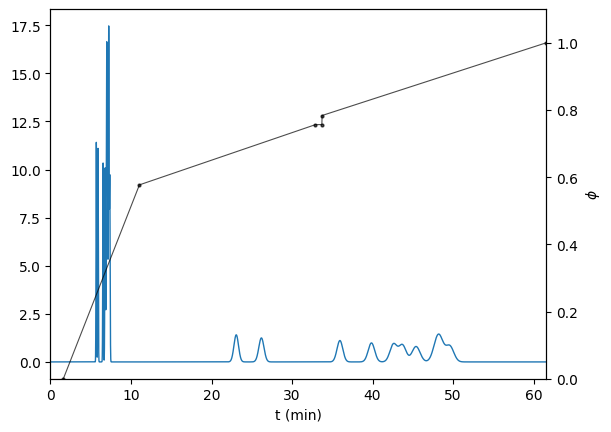

MEASUREMENT SO  24  RES SCORE  12.896115138319388 TIME SCORE 37.68891400483931 TOT SCORE 12.896115138319388


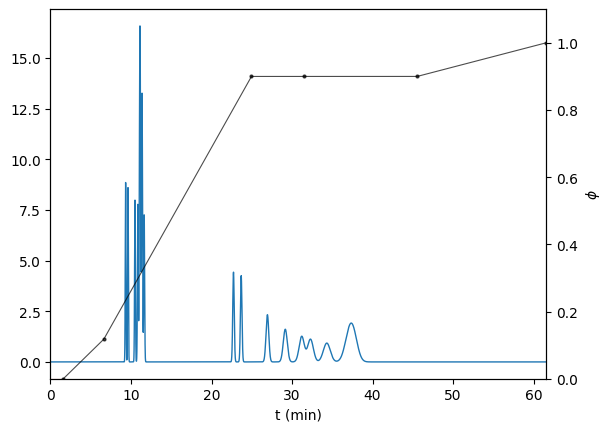

Trial  1
INITIAL MEASUREMENT  0  RES SCORE  7.9930453635131355 TIME SCORE 65.8271530951557 TOT SCORE 7.9923870919821836


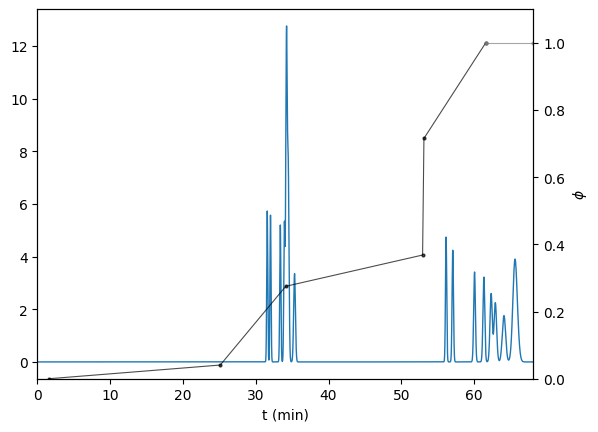

INITIAL MEASUREMENT  1  RES SCORE  12.228378136339764 TIME SCORE 61.69001686645061 TOT SCORE 12.2277612361711


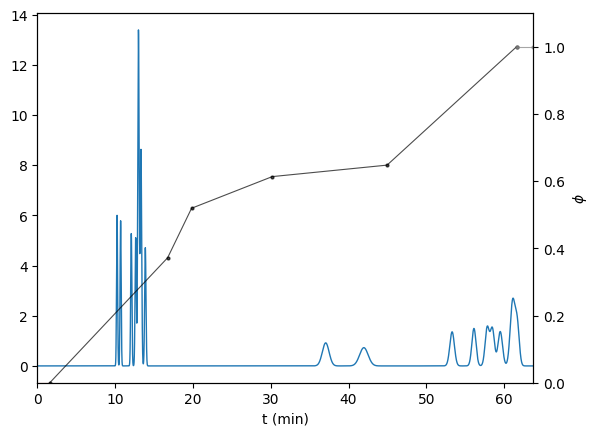

INITIAL MEASUREMENT  2  RES SCORE  12.511915085889926 TIME SCORE 51.465572551892826 TOT SCORE 12.511400430164407


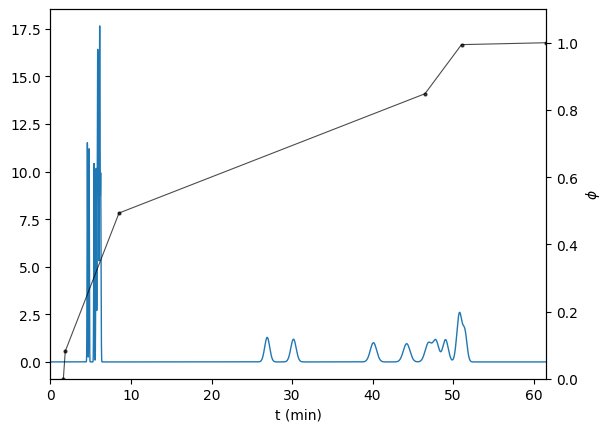

INITIAL MEASUREMENT  3  RES SCORE  12.6431335160712 TIME SCORE 54.654678599864994 TOT SCORE 12.642586969285201


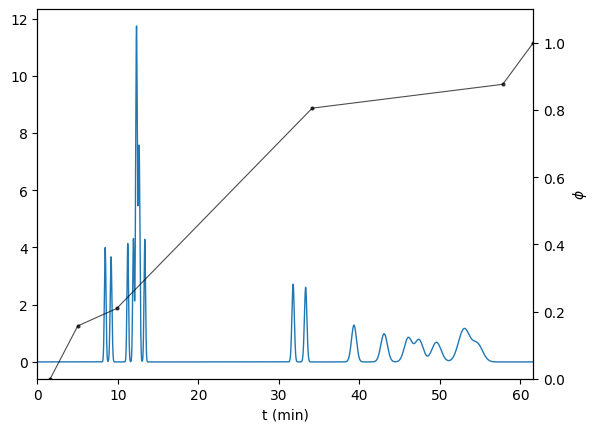

INITIAL MEASUREMENT  4  RES SCORE  12.553910505794795 TIME SCORE 56.49093441244006 TOT SCORE 12.55334559645067


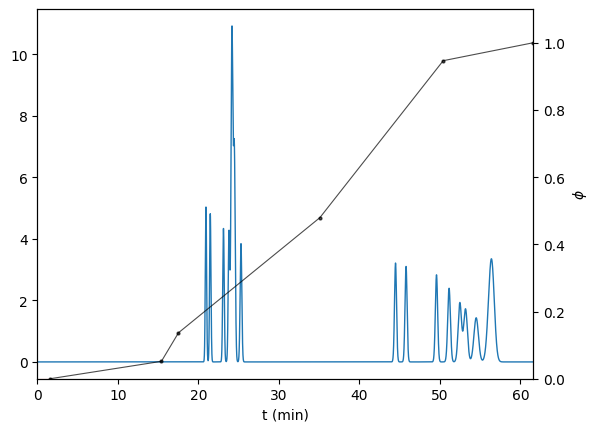

INITIAL MEASUREMENT  5  RES SCORE  12.400142088341312 TIME SCORE 43.43348487603141 TOT SCORE 12.399707753492551


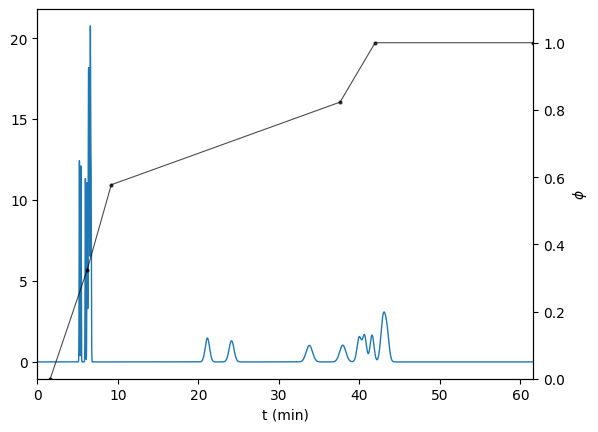

INITIAL MEASUREMENT  6  RES SCORE  5.509539121761731 TIME SCORE 68.98008247720637 TOT SCORE 5.5088493209369584


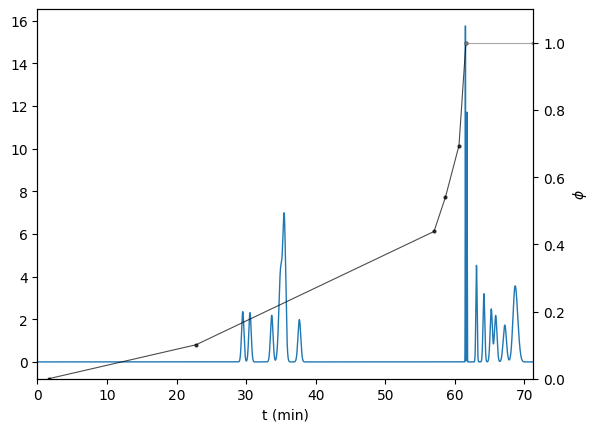

INITIAL MEASUREMENT  7  RES SCORE  12.579378017966864 TIME SCORE 44.22810779393912 TOT SCORE 12.578935736888925


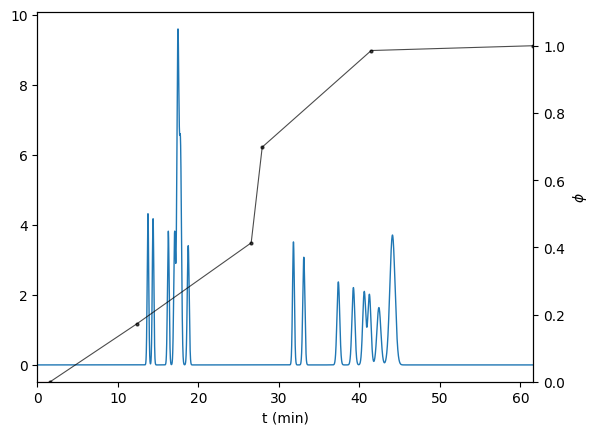

INITIAL MEASUREMENT  8  RES SCORE  11.250330724613498 TIME SCORE 62.34814311764703 TOT SCORE 11.249707243182321


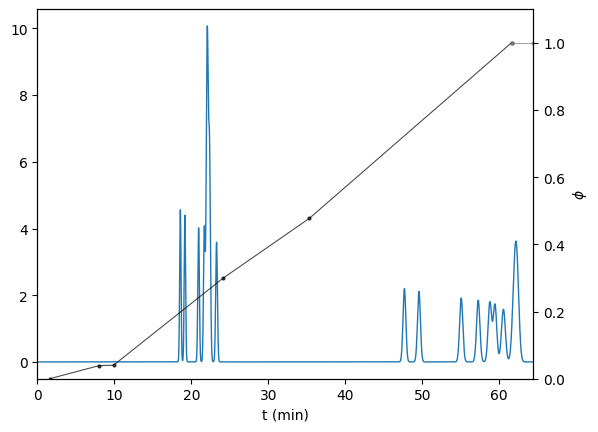

INITIAL MEASUREMENT  9  RES SCORE  11.135531898227292 TIME SCORE 41.56296564216419 TOT SCORE 11.13511626857087


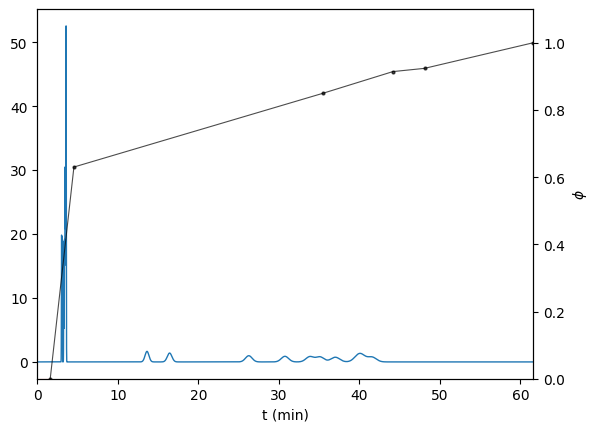

MEASUREMENT SO  0  RES SCORE  11.283467049424422 TIME SCORE 51.53334769860869 TOT SCORE 11.283467049424422


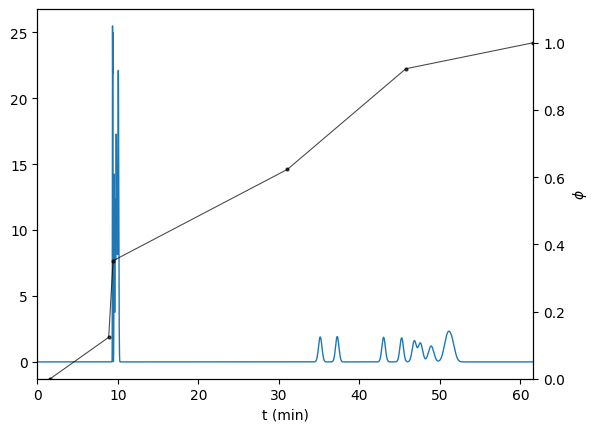

MEASUREMENT SO  1  RES SCORE  12.927521350516566 TIME SCORE 45.574095183528584 TOT SCORE 12.927521350516566


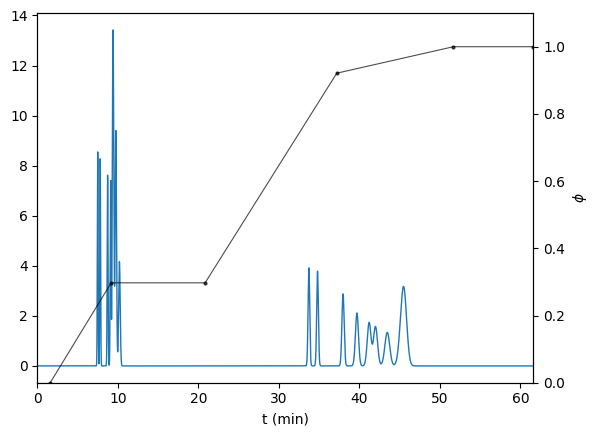

MEASUREMENT SO  2  RES SCORE  12.302123052790872 TIME SCORE 49.679798431546736 TOT SCORE 12.302123052790872


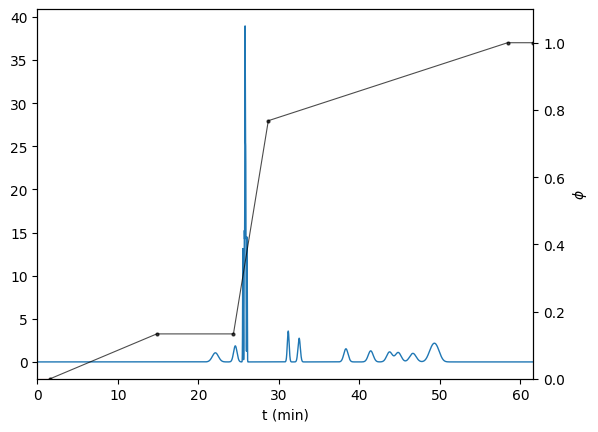

MEASUREMENT SO  3  RES SCORE  12.537087857891992 TIME SCORE 44.52017414109189 TOT SCORE 12.537087857891992


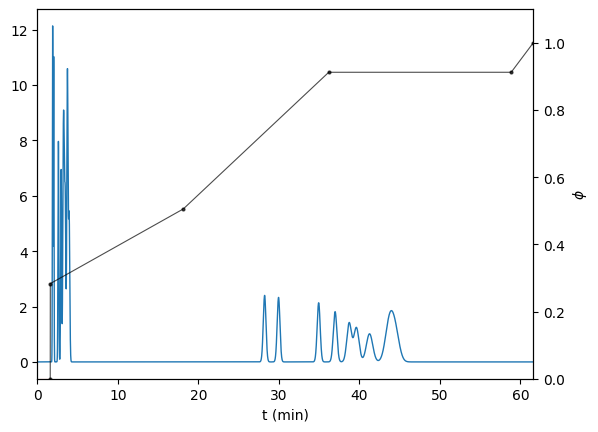

MEASUREMENT SO  4  RES SCORE  12.751198190063258 TIME SCORE 53.50098124325632 TOT SCORE 12.751198190063258


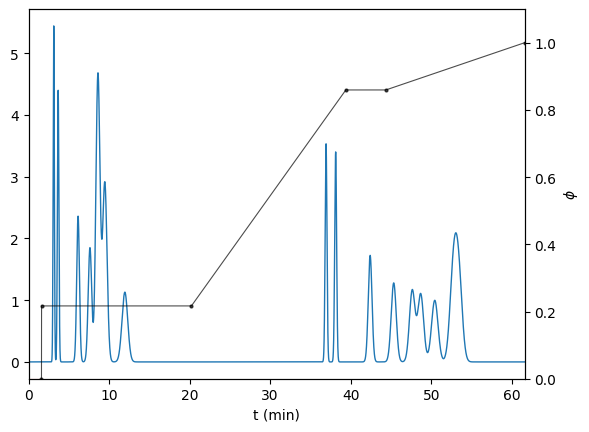

MEASUREMENT SO  5  RES SCORE  12.876455720154548 TIME SCORE 51.813573256506665 TOT SCORE 12.876455720154548


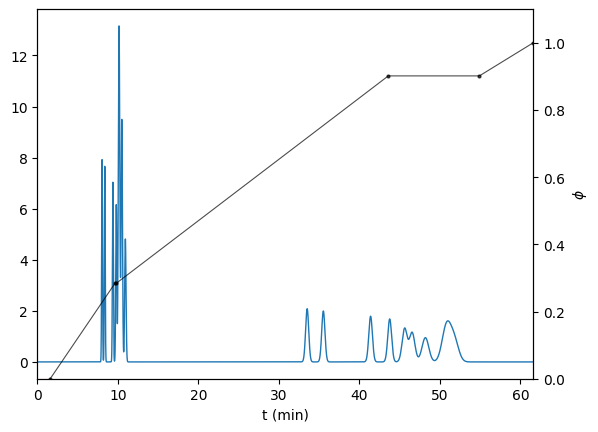

MEASUREMENT SO  6  RES SCORE  12.83798075914433 TIME SCORE 56.9191720127665 TOT SCORE 12.83798075914433


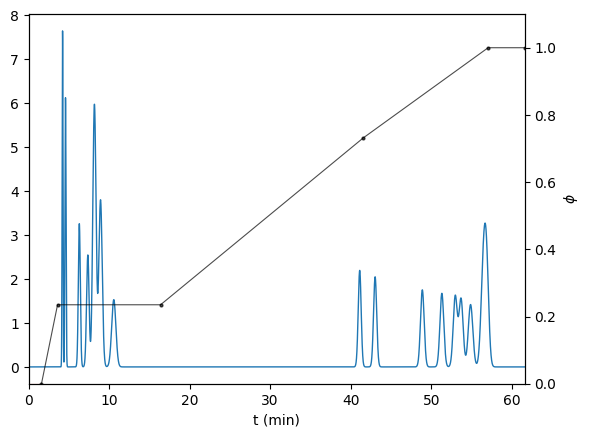

MEASUREMENT SO  7  RES SCORE  12.517701180085067 TIME SCORE 44.44137463814081 TOT SCORE 12.517701180085067


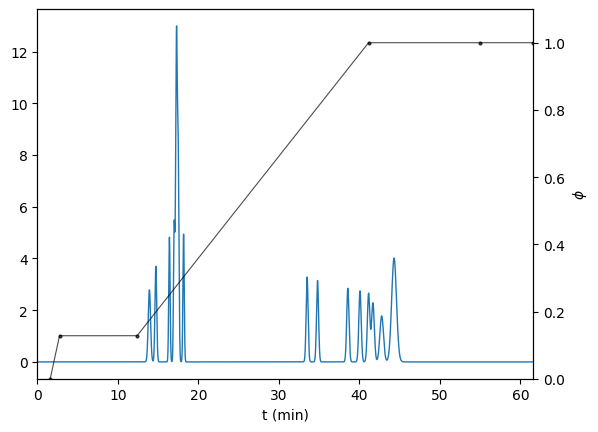

MEASUREMENT SO  8  RES SCORE  12.387152280872085 TIME SCORE 58.416449019495104 TOT SCORE 12.387152280872085


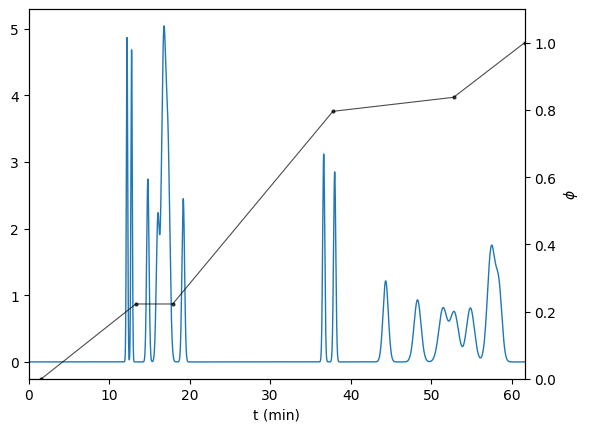

MEASUREMENT SO  9  RES SCORE  9.720397403050224 TIME SCORE 46.39219226045338 TOT SCORE 9.720397403050224


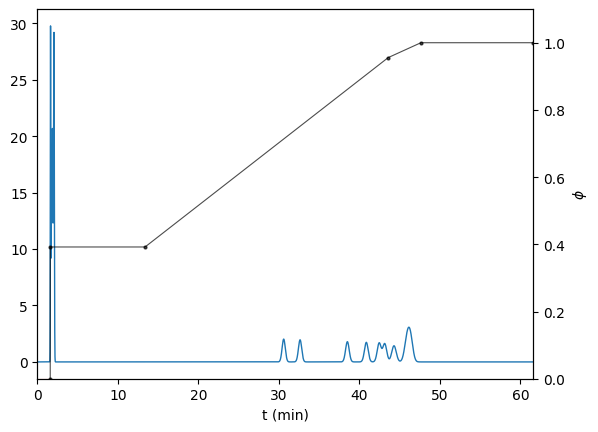

MEASUREMENT SO  10  RES SCORE  12.827734124697635 TIME SCORE 44.36949807491279 TOT SCORE 12.827734124697635


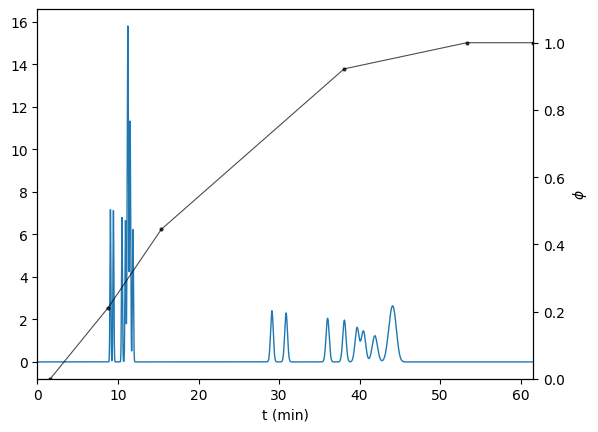

MEASUREMENT SO  11  RES SCORE  12.837639297390513 TIME SCORE 46.35263177141731 TOT SCORE 12.837639297390513


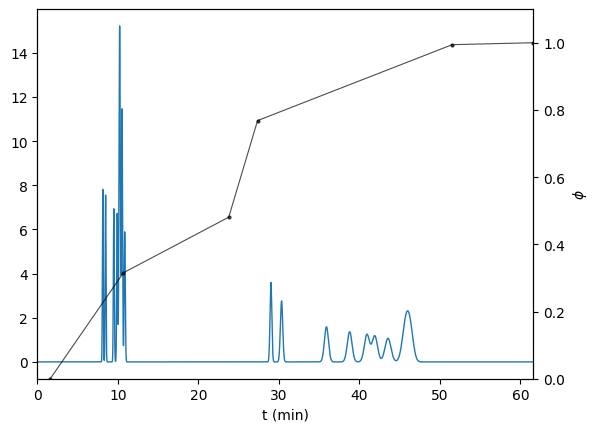

MEASUREMENT SO  12  RES SCORE  12.79628707293973 TIME SCORE 48.315652337255955 TOT SCORE 12.79628707293973


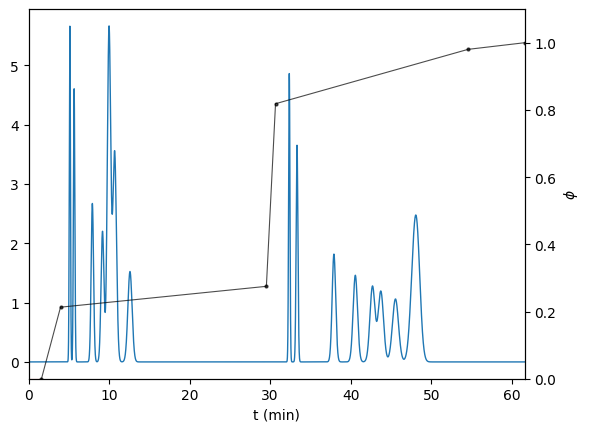

MEASUREMENT SO  13  RES SCORE  13.030451313646402 TIME SCORE 43.91522836016125 TOT SCORE 13.030451313646402


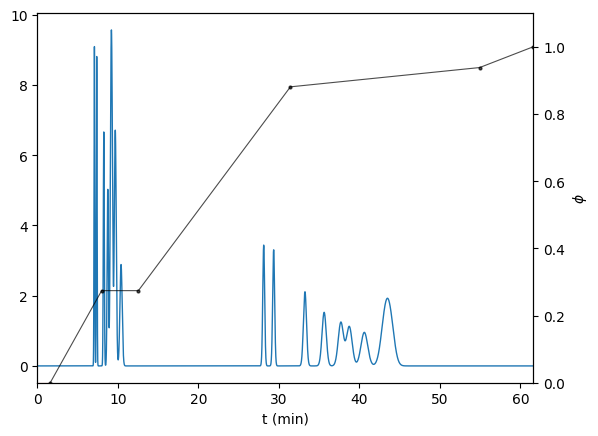

MEASUREMENT SO  14  RES SCORE  13.005195707323297 TIME SCORE 40.95583483728529 TOT SCORE 13.005195707323297


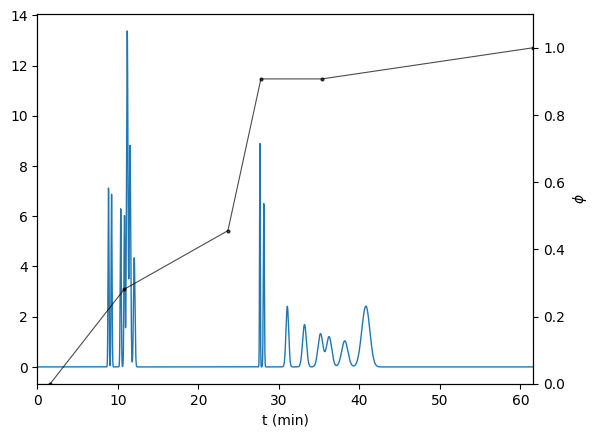

MEASUREMENT SO  15  RES SCORE  12.941410740455384 TIME SCORE 52.46016344341695 TOT SCORE 12.941410740455384


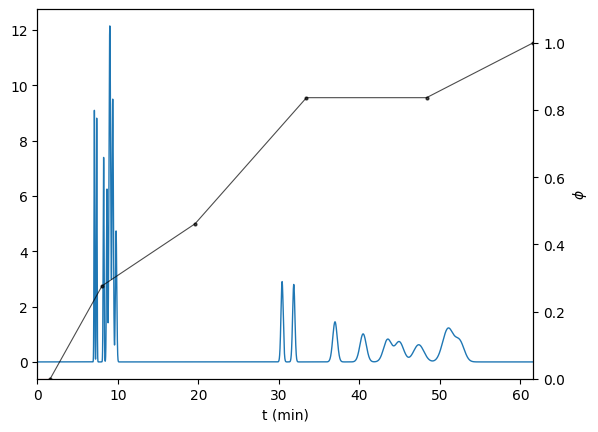

MEASUREMENT SO  16  RES SCORE  13.201109096576772 TIME SCORE 40.77369063920068 TOT SCORE 13.201109096576772


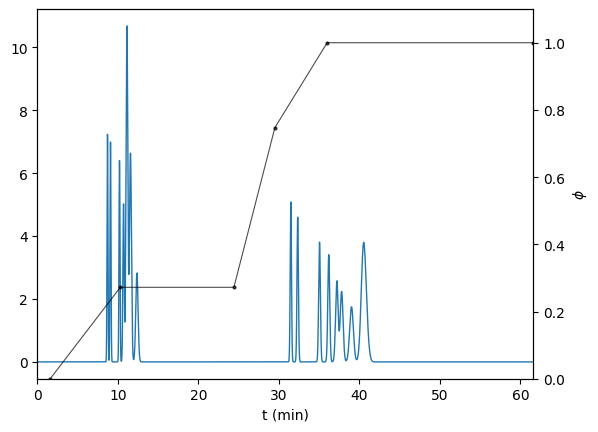

MEASUREMENT SO  17  RES SCORE  12.816231014907709 TIME SCORE 40.502788999045755 TOT SCORE 12.816231014907709


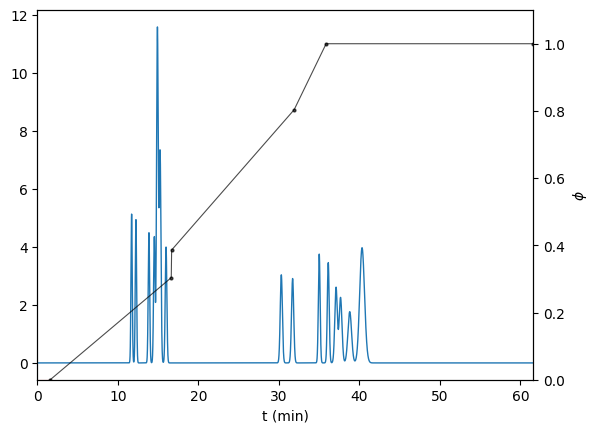

MEASUREMENT SO  18  RES SCORE  11.901832890864407 TIME SCORE 51.419381620384264 TOT SCORE 11.901832890864407


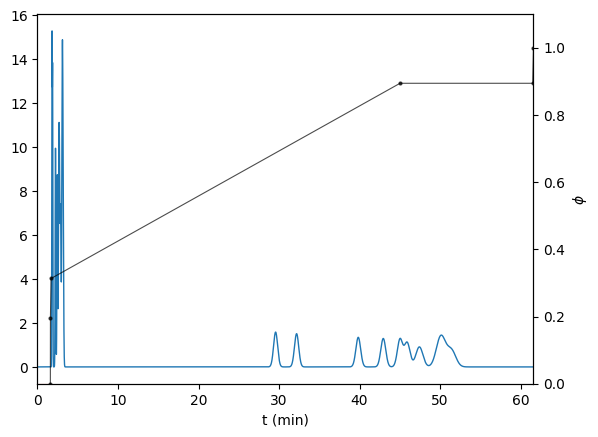

MEASUREMENT SO  19  RES SCORE  12.680510293754327 TIME SCORE 59.205541566533554 TOT SCORE 12.680510293754327


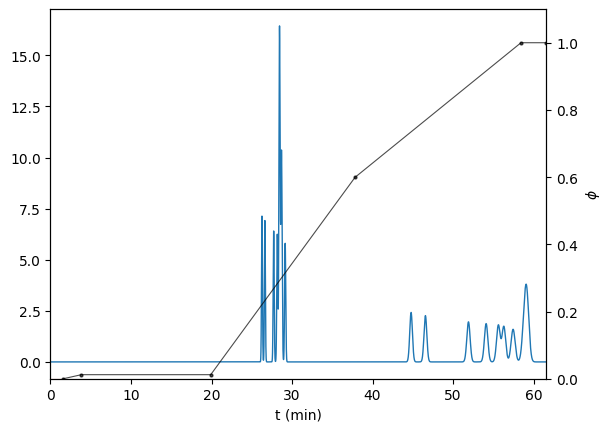

MEASUREMENT SO  20  RES SCORE  13.062937187073302 TIME SCORE 42.12747724010347 TOT SCORE 13.062937187073302


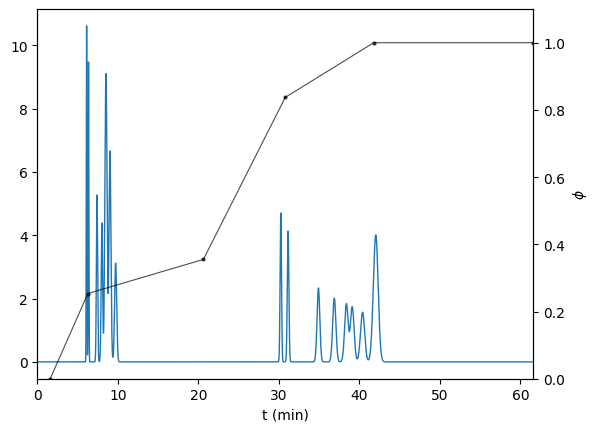

MEASUREMENT SO  21  RES SCORE  13.199962722314773 TIME SCORE 35.609071777610566 TOT SCORE 13.199962722314773


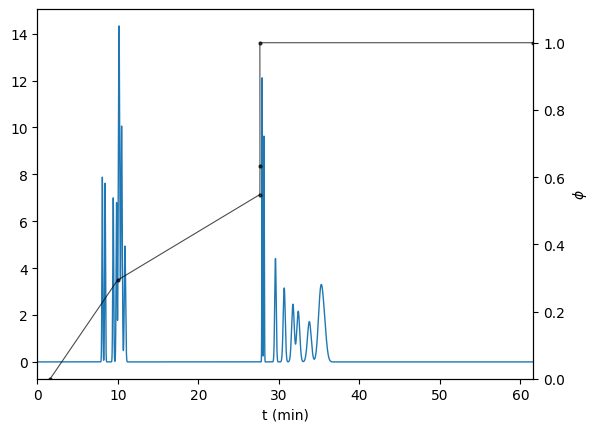

MEASUREMENT SO  22  RES SCORE  13.142771042312352 TIME SCORE 33.36996463755899 TOT SCORE 13.142771042312352


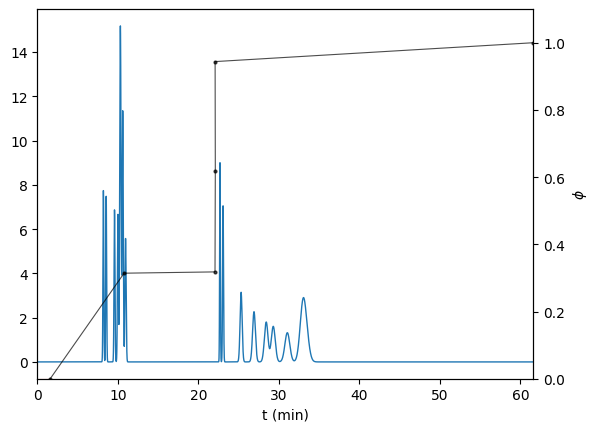

MEASUREMENT SO  23  RES SCORE  13.334144590252077 TIME SCORE 35.96869483338861 TOT SCORE 13.334144590252077


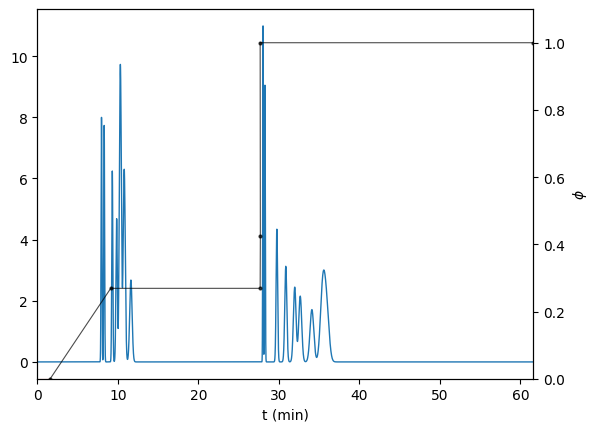

MEASUREMENT SO  24  RES SCORE  13.149727529226633 TIME SCORE 34.7364372737962 TOT SCORE 13.149727529226633


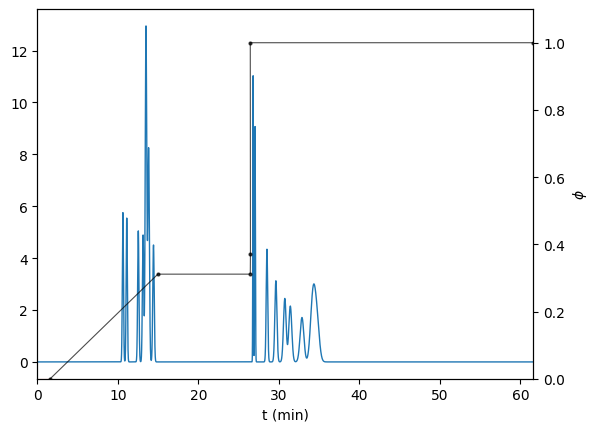

In [10]:
# Let's now set up a Bayesian optimization loop for the single-objective case.

# Set some fixed parameters
fixed_phi_pars = [[0.], [1.]] # fixed phi points
fixed_time_pars = [[0.], [60.]] # at fixed time points

# We will optimize 8 parameters (4 gradient nodes) for which we set bounds.
# phi points between 0.01 and 1 modifier fraction and tim between 0.01 and 59.9 minutes
# lower and upper bounds of parameters phi1, phi2, phi3, phi4, t1, t2, t3, t4
bounds = torch.stack([torch.tensor([0.01, 0.01, 0.01, 0.01,  0.01, 0.01, 0.01, 0.01]),
                      torch.tensor([1, 1, 1, 1., 59.9, 59.9, 59.9, 59.9])])

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(8), torch.ones(8)])

# number of random initial experiments
init_measurements = 10

# optimization budget
iterations = 25

# number of trials
trials = 2

# prefacs to scalarize multiple objectives into a single scalar value
prefacs = [1, 1e-5] # this means there is a heavy focus on resolution

# create some lists to store results in
scores_so_all = []
seperate_scores_so_all = []
pars_so_all = []

# Loop over trials
for trial in range(trials):
    print('Trial ', trial)
    
    # Set random seed for reproducibility
    seed_everything(trial)
    
    # create lists to fill with results per trial
    scores_so = []
    seperate_scores_so = []
    pars_so = []
    
    # generate initial experiments
    pars = generate_initial_sorted_data(bounds, n=init_measurements)
    pars_so = pars
    # convert to parameters that retention modeling code can handle
    phi_list, t_list = bo_to_rm(pars, fixed_phi_pars, fixed_time_pars)
    
    # Perform random initial experiments
    for i in range(len(phi_list)):
        tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[i], t_list[i], N)
        score = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore = -np.max(tR_list)

        score_so = (score*prefacs[0]) + (maxtimescore * prefacs[1])
        score_seperate_so = [score, maxtimescore]

        print('INITIAL MEASUREMENT ', i, ' RES SCORE ', score, 'TIME SCORE', -maxtimescore, 'TOT SCORE', score_so)
        plot_chromatogram(tR_list, W_list, phi_list[i], t_list[i], t_D, t_0, t_init)

        scores_so.append(score_so)
        seperate_scores_so.append(score_seperate_so)
    
    # Now we are ready to do BO loop
    for iteration in range(iterations):
        # perform BO round
        new_pars_so = BO_round(bounds, norm_bounds, np.array(scores_so), pars_so)

        phi_list_so, t_list_so = bo_to_rm(new_pars_so, fixed_phi_pars, fixed_time_pars)

        # perform experiments
        tR_list_so, W_list_so = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_so[0], 
                                                     t_list_so[0],N)
        # compute scores
        score_so = capped_sum_of_resolutions(tR_list_so, W_list_so, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore_so = -np.max(tR_list_so)

        print('MEASUREMENT SO ', iteration, ' RES SCORE ', score_so, 'TIME SCORE', -maxtimescore_so, 'TOT SCORE', score_so)
        plot_chromatogram(tR_list_so, W_list_so, phi_list_so[0], t_list_so[0], t_D, t_0, t_init)

        score_seperate_so = [score_so, maxtimescore_so]
        score_so = (score_so*prefacs[0]) +  (maxtimescore_so*prefacs[1])

        # update training data
        # update scores
        scores_so.append(score_so)
        seperate_scores_so.append(score_seperate_so)

        # update pars
        pars_so = np.concatenate((pars_so, new_pars_so), axis=0)
    
    # after each trial, append all values to list
    scores_so_all.append(scores_so)
    seperate_scores_so_all.append(seperate_scores_so)
    pars_so_all.append(pars_so)


### Let's visualize some results

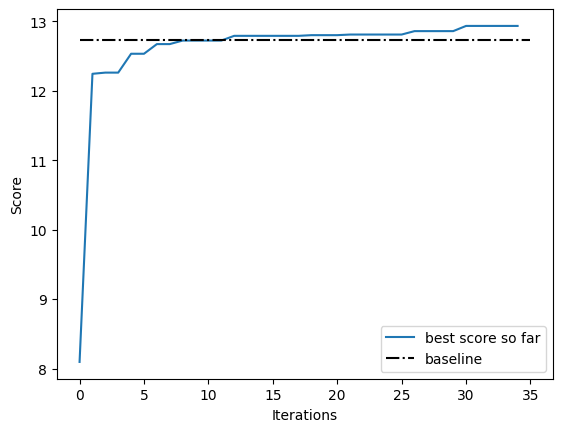

Measurement  30


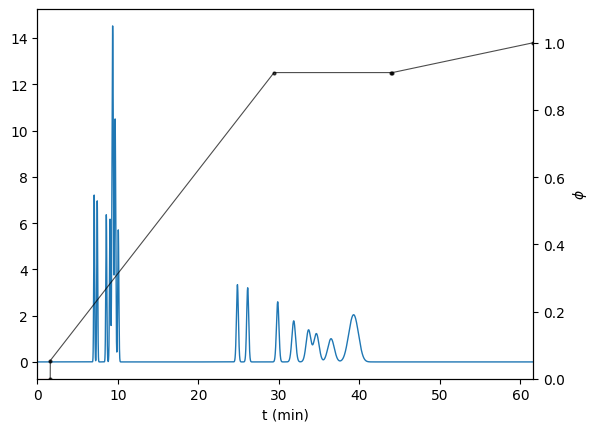

In [11]:
scores_best_so_far = best_so_far(np.array(scores_so_all))

trial_to_observe = 0
# plot best observed scores at each iteration
plt.plot(scores_best_so_far[trial_to_observe], label='best score so far')

# plot score of handpicked program
baseline = score_ms * prefacs[0] + time_score_ms * prefacs[1]
plt.hlines(baseline, 0, len(scores_so_all[trial_to_observe]), ls='-.', label='baseline', color='black')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.show()


# plot best measurement (according to score function)
idxloc = np.argmax(scores_so_all[trial_to_observe])
best_pars = np.reshape(np.array(pars_so_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)


In [12]:
# When running multiple trials, uncomment for plot with error bars
# scores_best_so_far = best_so_far(np.array(scores_so_all))
# mean_scores = np.mean(scores_best_so_far, axis=0)
# cis = ci(scores_best_so_far, trials)

# plt.plot(np.arange(len(mean_scores)), mean_scores, label='best score so far')
# plt.fill_between(np.arange(len(mean_scores)), mean_scores - cis, mean_scores + cis, alpha=0.6)
# plt.xlabel('Iterations')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.show()

### In similar fashion, we can set up a multi-objective BO loop

Trial  0
INITIAL MEASUREMENT  0  RES SCORE  8.096540311807626 TIME SCORE 66.63039470412889


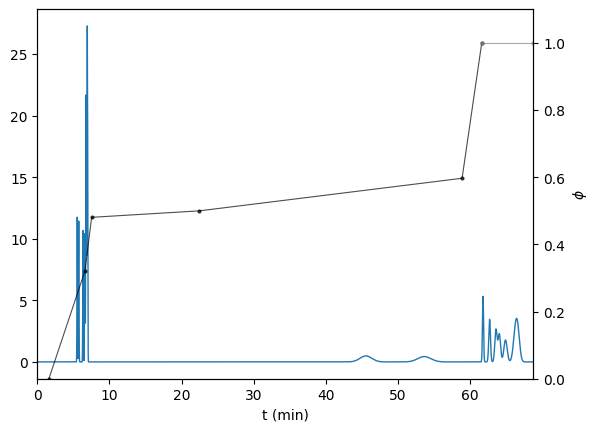

INITIAL MEASUREMENT  1  RES SCORE  12.244447653367132 TIME SCORE 60.52055116590354


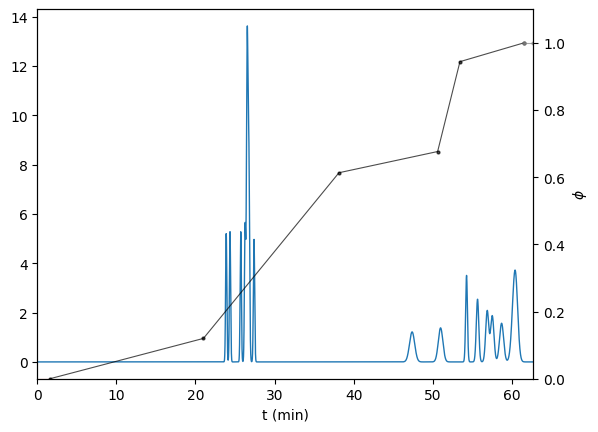

INITIAL MEASUREMENT  2  RES SCORE  12.261520725284369 TIME SCORE 56.357741284874045


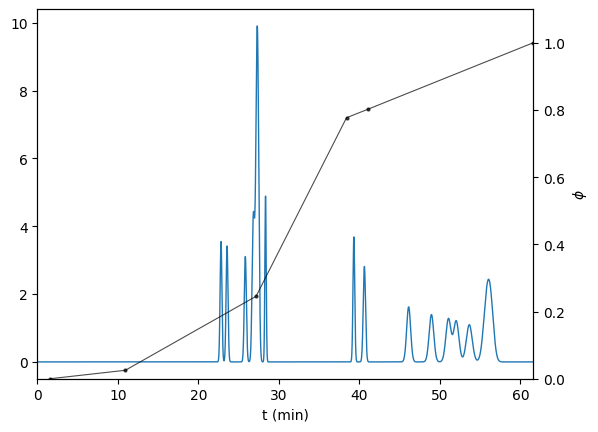

INITIAL MEASUREMENT  3  RES SCORE  8.841344664401719 TIME SCORE 64.31923442772293


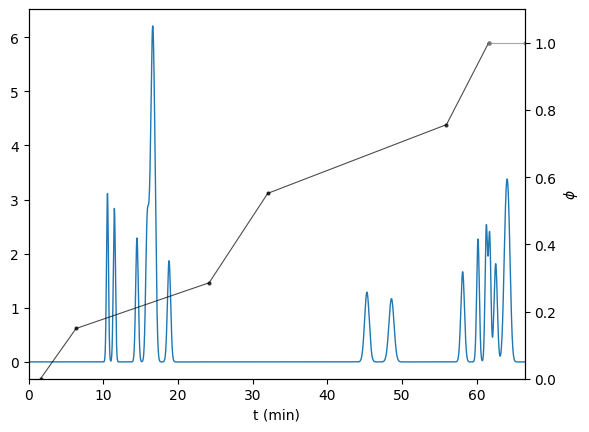

INITIAL MEASUREMENT  4  RES SCORE  12.532866437992698 TIME SCORE 36.393058196139776


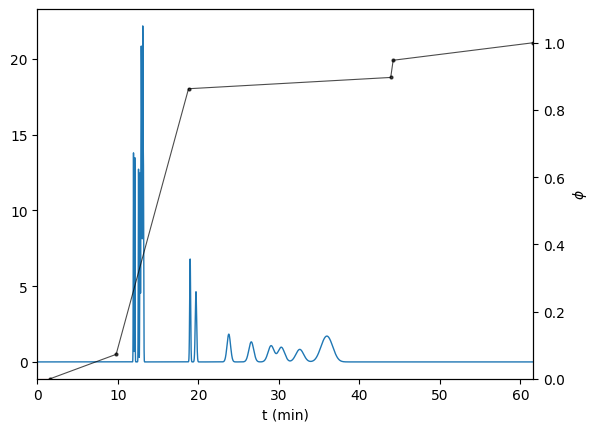

INITIAL MEASUREMENT  5  RES SCORE  10.338325756113619 TIME SCORE 63.447147176481096


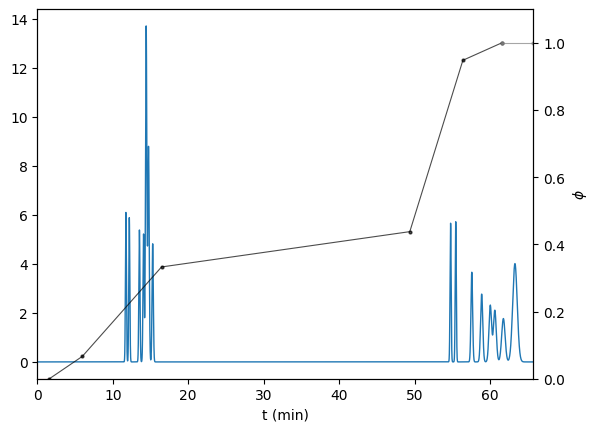

INITIAL MEASUREMENT  6  RES SCORE  12.672044432760591 TIME SCORE 54.92420637974644


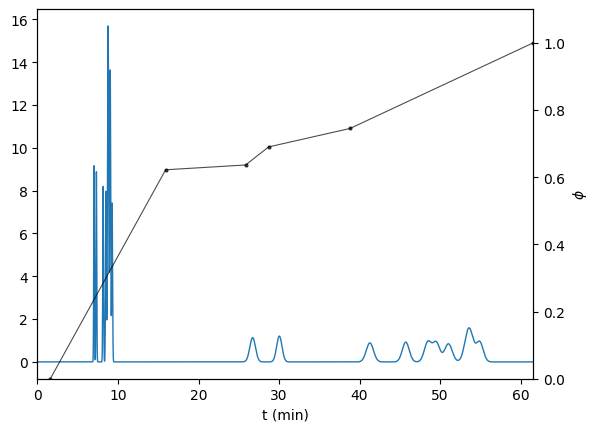

INITIAL MEASUREMENT  7  RES SCORE  5.557399428508089 TIME SCORE 69.32178955521617


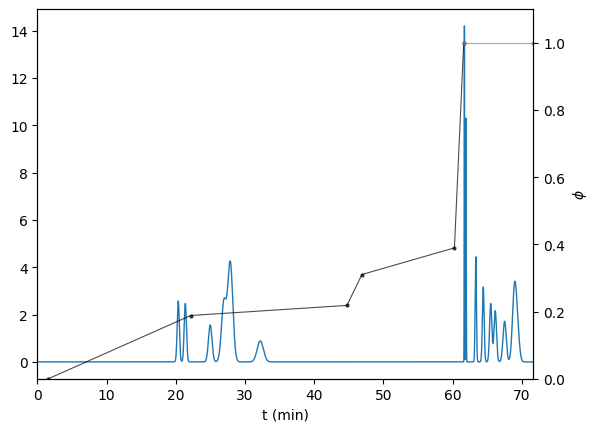

INITIAL MEASUREMENT  8  RES SCORE  12.722960236557503 TIME SCORE 53.21481517994945


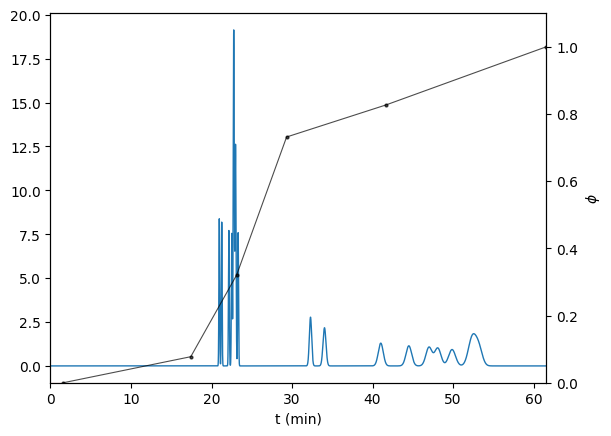

INITIAL MEASUREMENT  9  RES SCORE  10.119821344453445 TIME SCORE 63.66499675277798


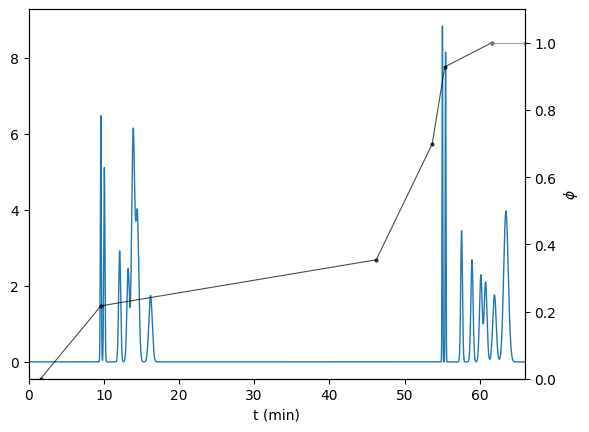

MEASUREMENT MO  0  RES SCORE  11.844275941443632 TIME SCORE 40.45857034343433


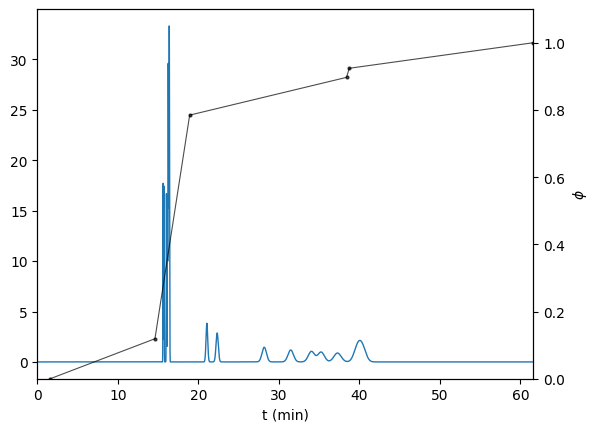

MEASUREMENT MO  1  RES SCORE  11.518259051973434 TIME SCORE 31.699304856007377


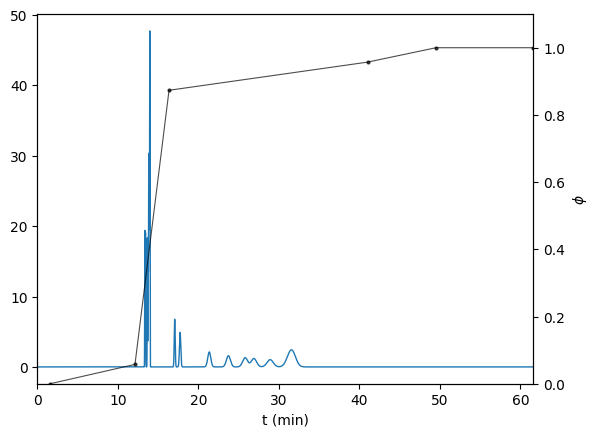

MEASUREMENT MO  2  RES SCORE  10.900435451631756 TIME SCORE 21.166666640355107


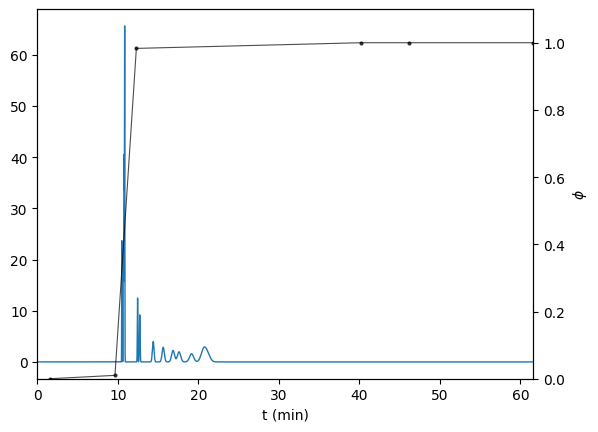

MEASUREMENT MO  3  RES SCORE  10.599937072413384 TIME SCORE 14.763671998615099


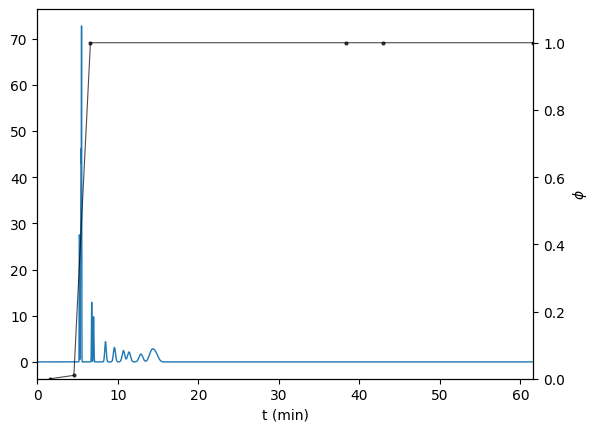

MEASUREMENT MO  4  RES SCORE  7.903514898180344 TIME SCORE 15.977539138158468


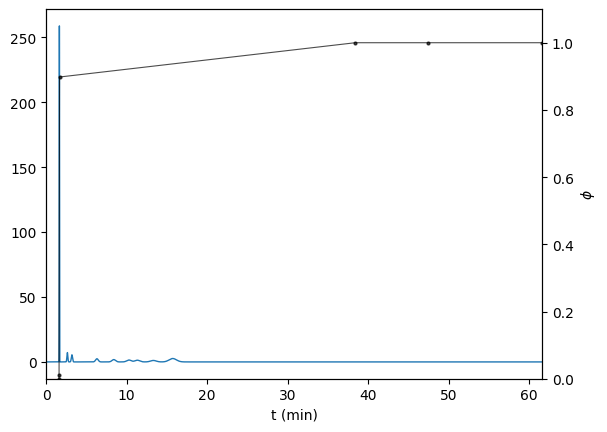

MEASUREMENT MO  5  RES SCORE  9.347141736686556 TIME SCORE 10.96923184759158


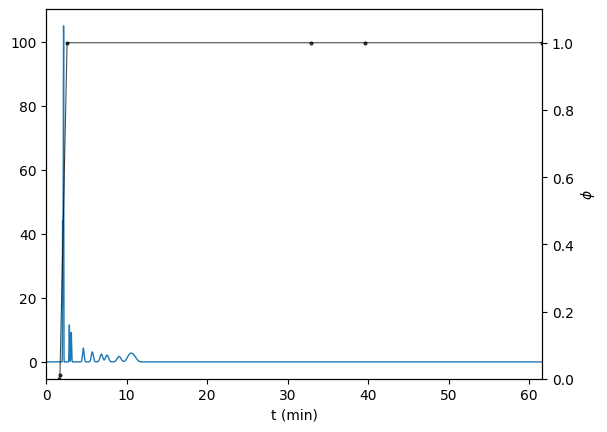

MEASUREMENT MO  6  RES SCORE  13.060896840105796 TIME SCORE 26.789567166369977


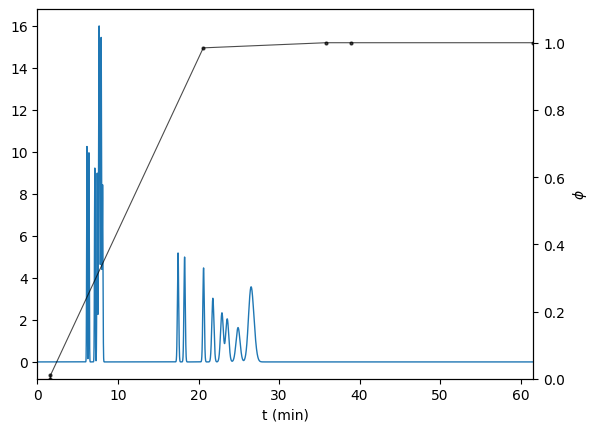

MEASUREMENT MO  7  RES SCORE  12.900079090817304 TIME SCORE 35.78520358172929


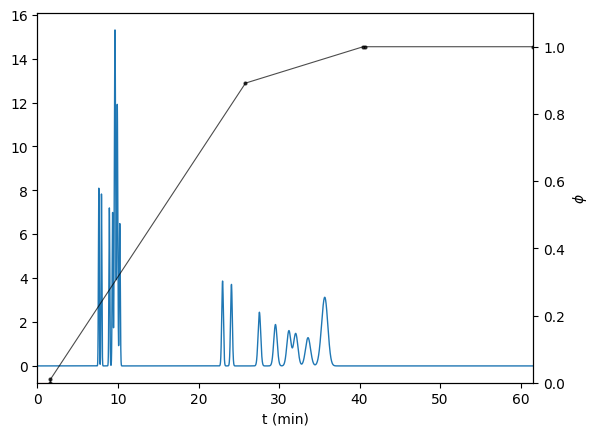

MEASUREMENT MO  8  RES SCORE  12.871978676923618 TIME SCORE 34.97917378611545


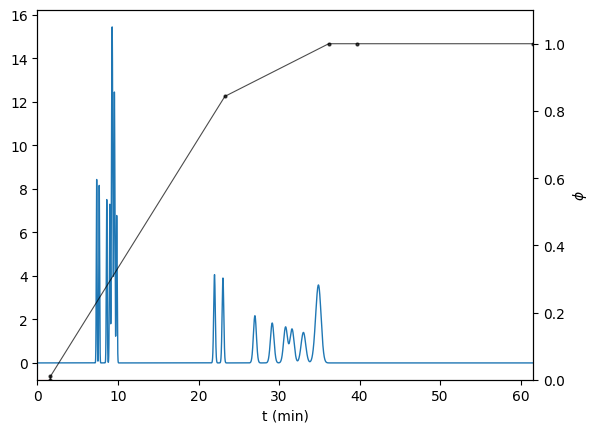

MEASUREMENT MO  9  RES SCORE  12.879706626947973 TIME SCORE 34.496635308492834


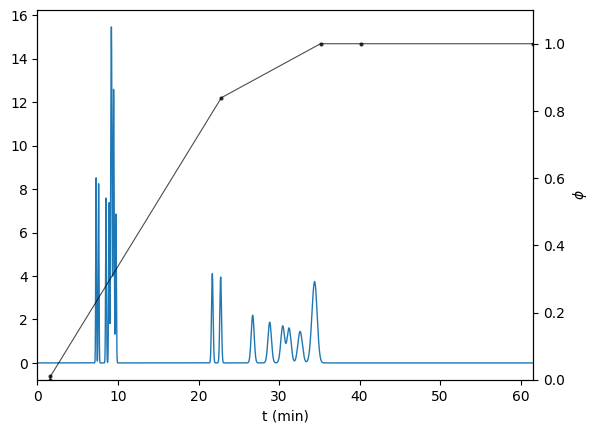

MEASUREMENT MO  10  RES SCORE  12.81676825096852 TIME SCORE 20.537957338947862


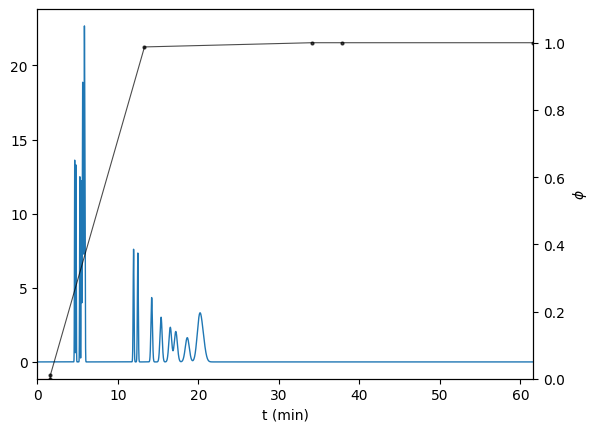

MEASUREMENT MO  11  RES SCORE  12.865978572432153 TIME SCORE 31.776556745028252


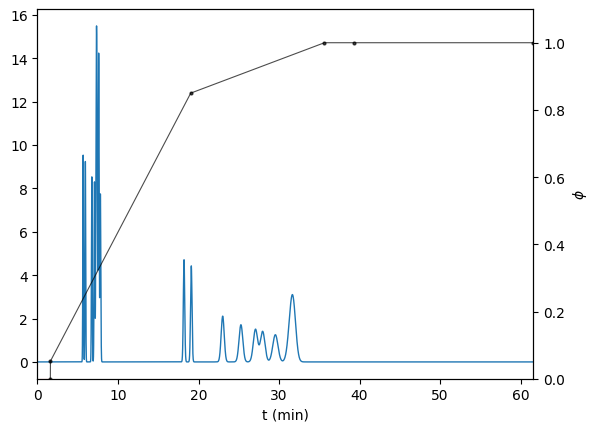

MEASUREMENT MO  12  RES SCORE  12.858945301928726 TIME SCORE 31.957661613464676


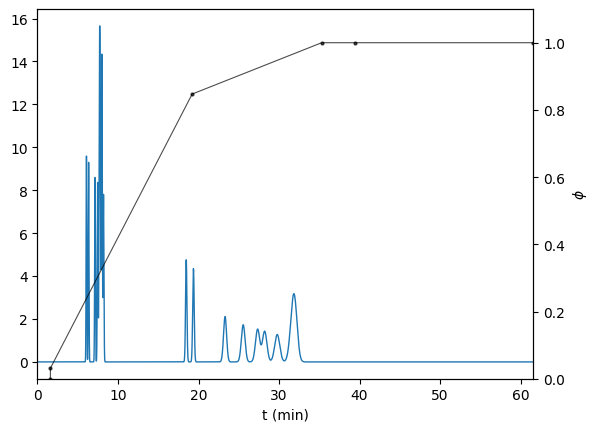

MEASUREMENT MO  13  RES SCORE  8.058539659551084 TIME SCORE 10.174032387937046


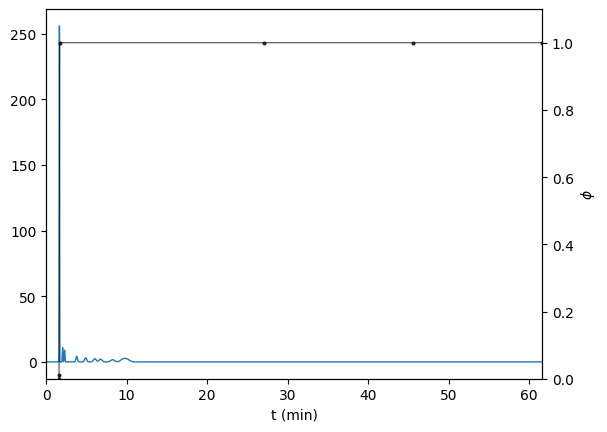

MEASUREMENT MO  14  RES SCORE  12.869761182633344 TIME SCORE 32.19651094410633


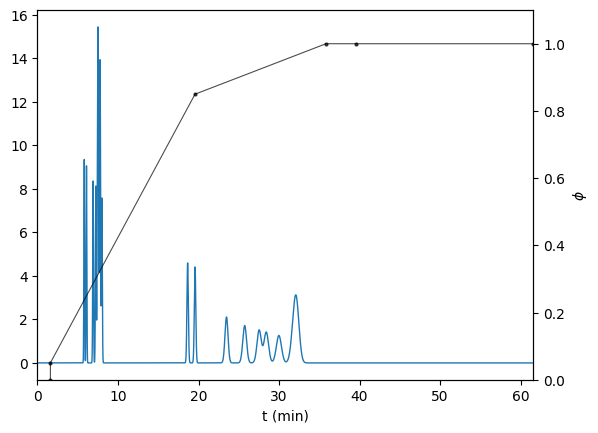

MEASUREMENT MO  15  RES SCORE  12.866546718596677 TIME SCORE 32.094247235604925


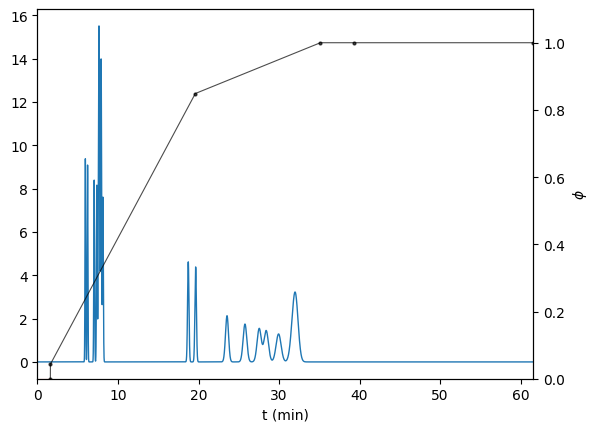

MEASUREMENT MO  16  RES SCORE  12.864652344237069 TIME SCORE 32.08570860554109


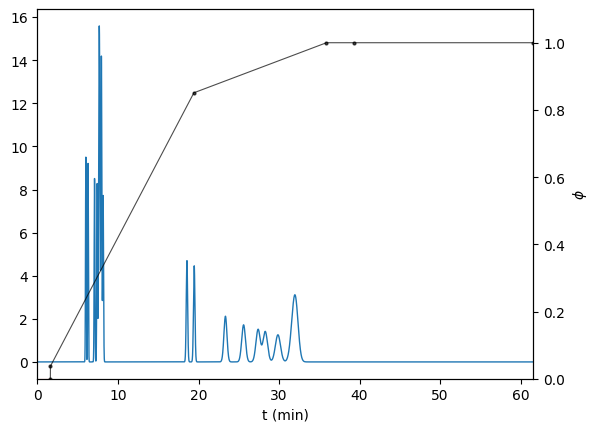

MEASUREMENT MO  17  RES SCORE  12.872638514063919 TIME SCORE 32.08027556165067


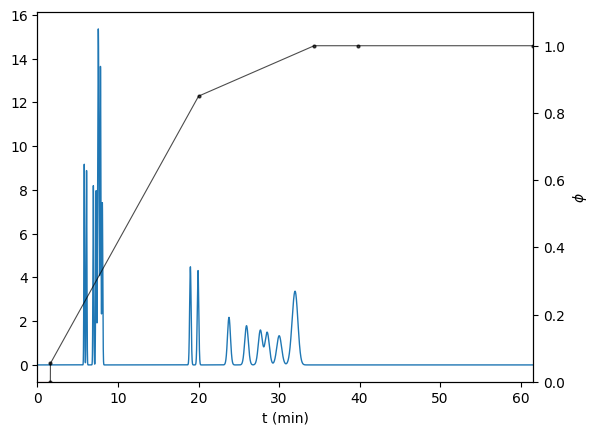

MEASUREMENT MO  18  RES SCORE  12.86958003831753 TIME SCORE 32.03091566100046


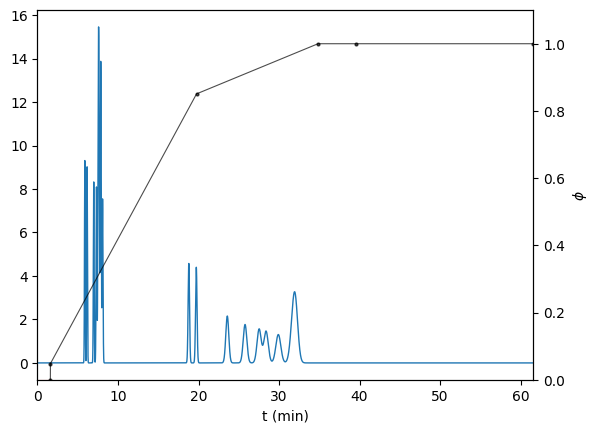

MEASUREMENT MO  19  RES SCORE  12.870020362748619 TIME SCORE 31.970788133940726


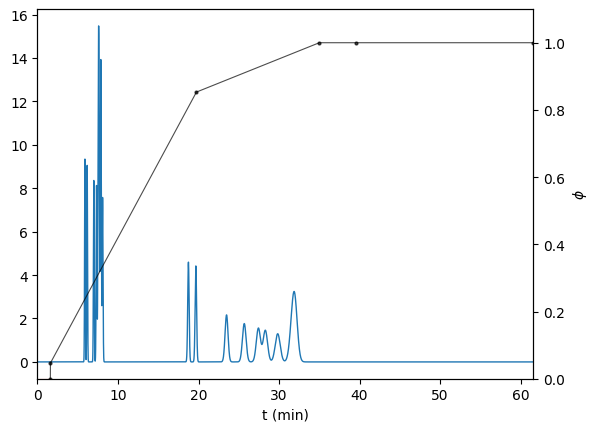

MEASUREMENT MO  20  RES SCORE  12.868874435146315 TIME SCORE 32.15892768567257


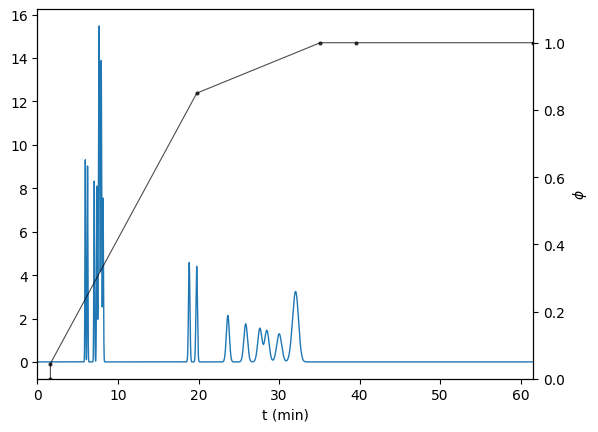

MEASUREMENT MO  21  RES SCORE  12.869885596101296 TIME SCORE 32.11075960754421


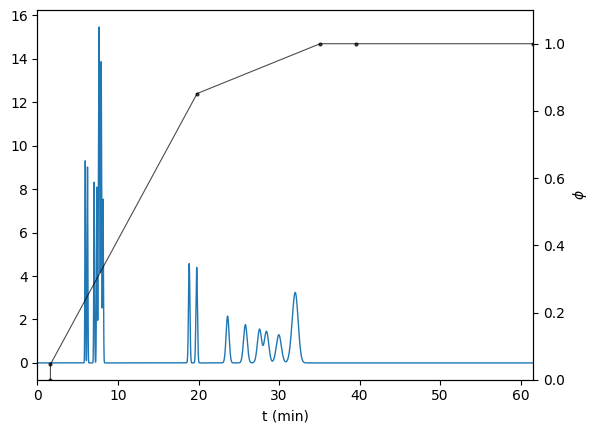

MEASUREMENT MO  22  RES SCORE  12.86988157694347 TIME SCORE 32.06733002709558


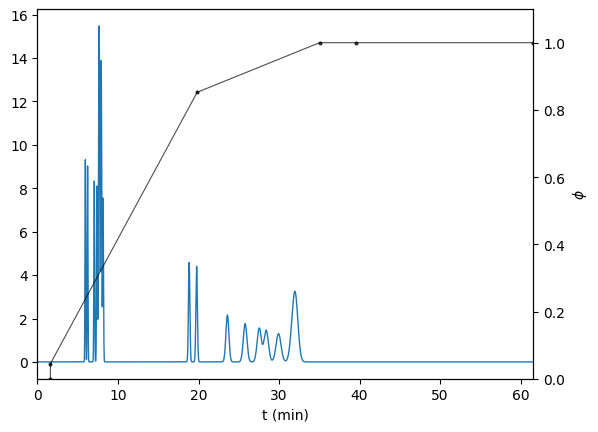

MEASUREMENT MO  23  RES SCORE  12.868473080616331 TIME SCORE 32.1748500281434


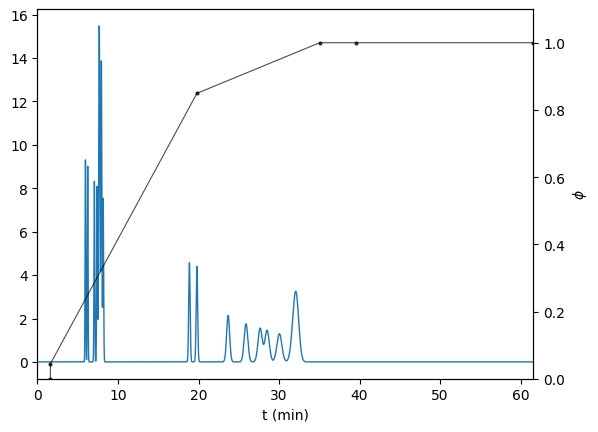

MEASUREMENT MO  24  RES SCORE  12.869590407976734 TIME SCORE 32.04939331738987


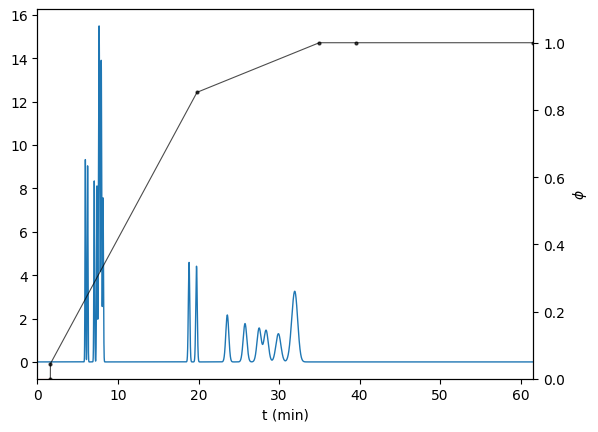

Trial  1
INITIAL MEASUREMENT  0  RES SCORE  7.9930453635131355 TIME SCORE 65.8271530951557


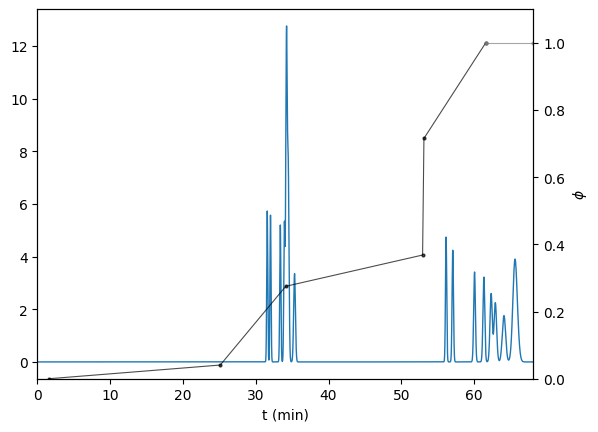

INITIAL MEASUREMENT  1  RES SCORE  12.228378136339764 TIME SCORE 61.69001686645061


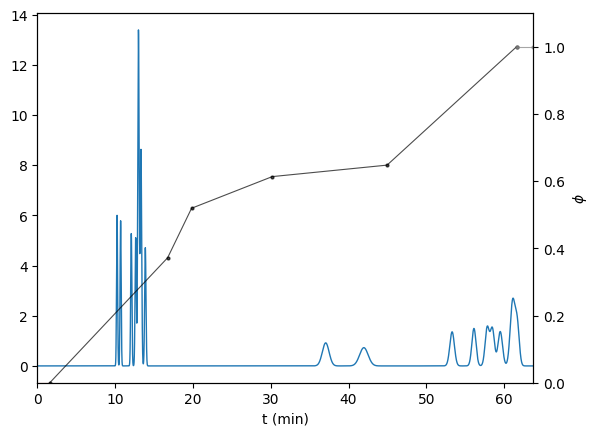

INITIAL MEASUREMENT  2  RES SCORE  12.511915085889926 TIME SCORE 51.465572551892826


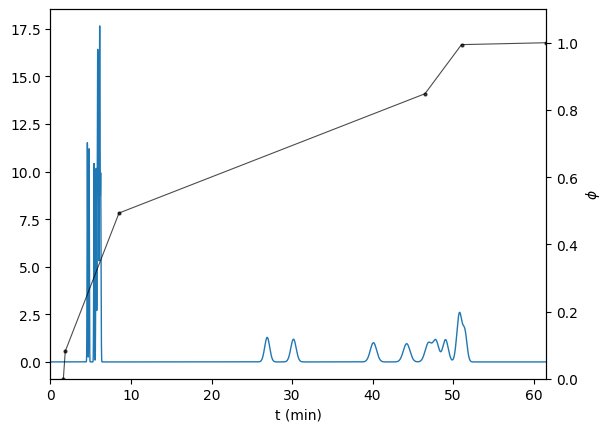

INITIAL MEASUREMENT  3  RES SCORE  12.6431335160712 TIME SCORE 54.654678599864994


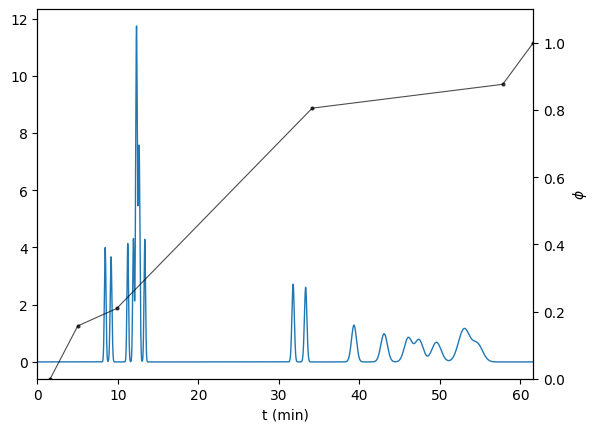

INITIAL MEASUREMENT  4  RES SCORE  12.553910505794795 TIME SCORE 56.49093441244006


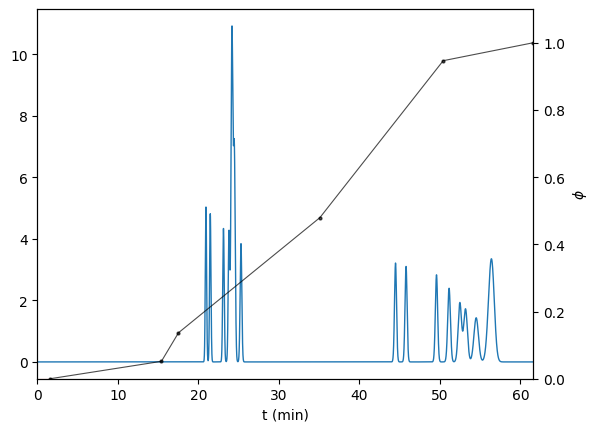

INITIAL MEASUREMENT  5  RES SCORE  12.400142088341312 TIME SCORE 43.43348487603141


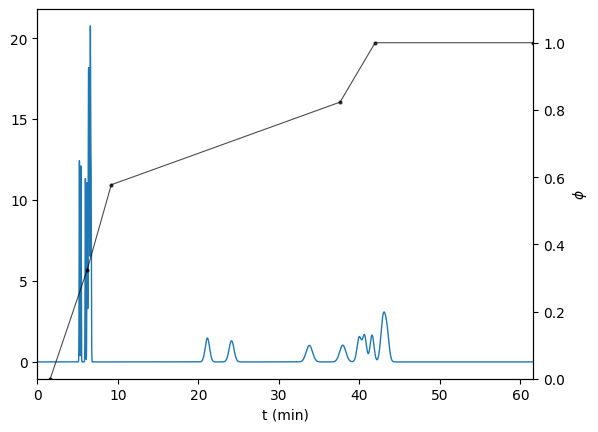

INITIAL MEASUREMENT  6  RES SCORE  5.509539121761731 TIME SCORE 68.98008247720637


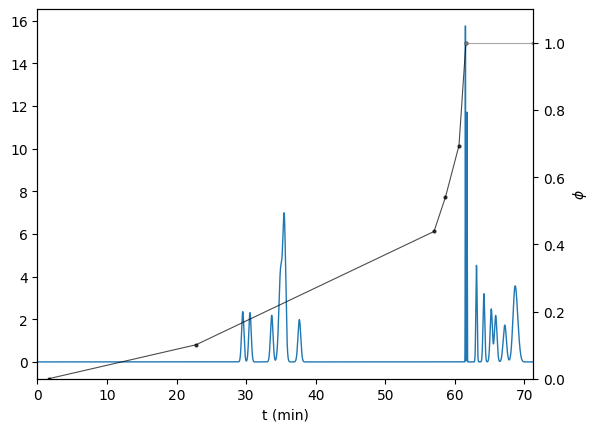

INITIAL MEASUREMENT  7  RES SCORE  12.579378017966864 TIME SCORE 44.22810779393912


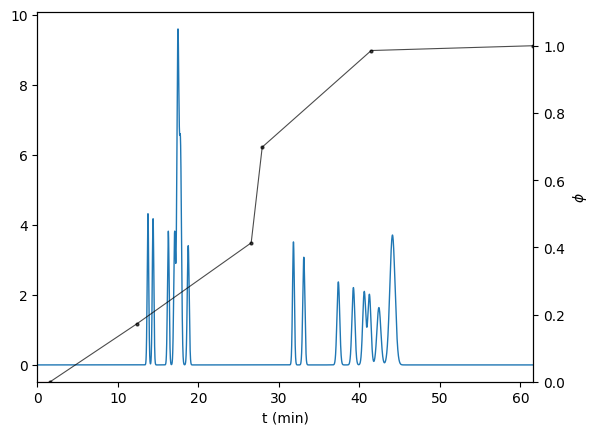

INITIAL MEASUREMENT  8  RES SCORE  11.250330724613498 TIME SCORE 62.34814311764703


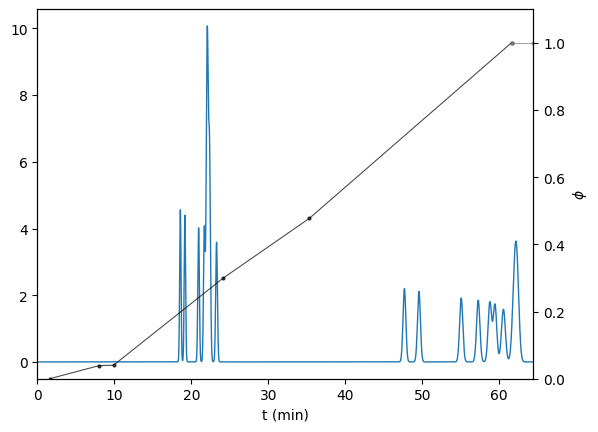

INITIAL MEASUREMENT  9  RES SCORE  11.135531898227292 TIME SCORE 41.56296564216419


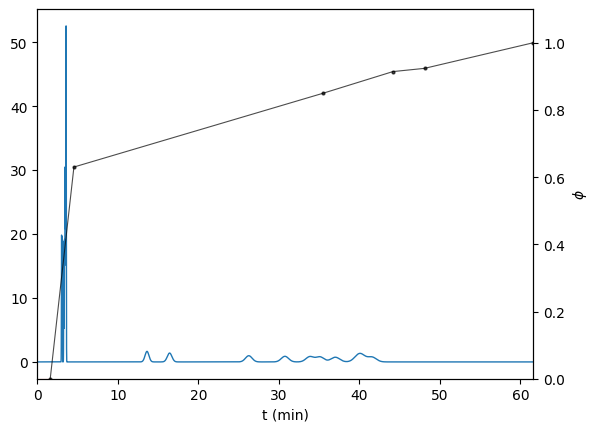

MEASUREMENT MO  0  RES SCORE  12.374721925175077 TIME SCORE 42.9684486082489


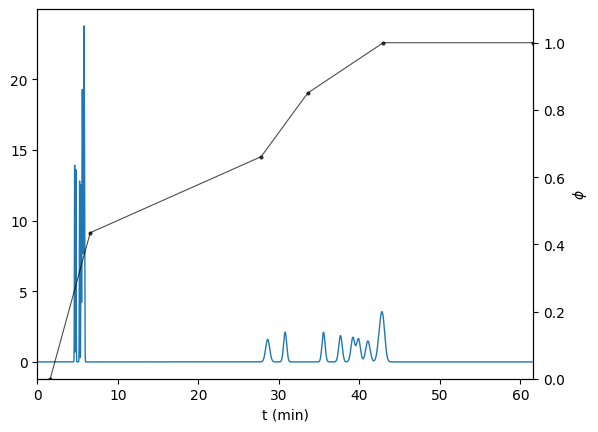

MEASUREMENT MO  1  RES SCORE  11.501817006127506 TIME SCORE 36.892285807441056


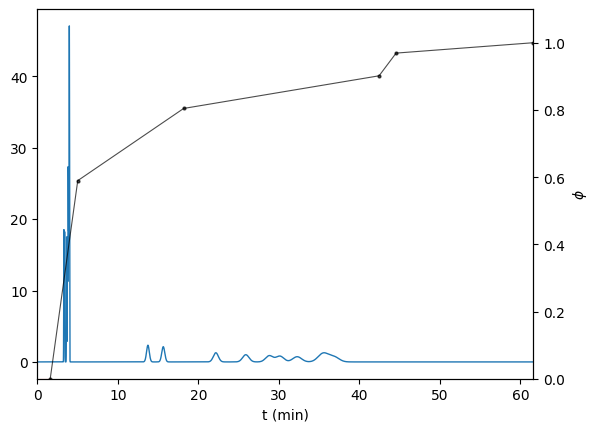

MEASUREMENT MO  2  RES SCORE  11.315359352152992 TIME SCORE 25.95705288492517


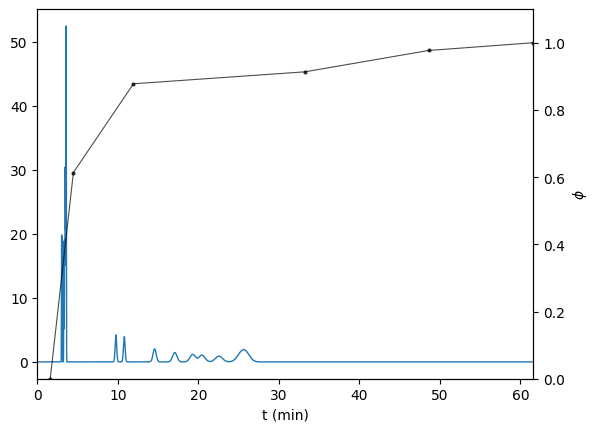

MEASUREMENT MO  3  RES SCORE  10.316337796167453 TIME SCORE 17.217178801714354


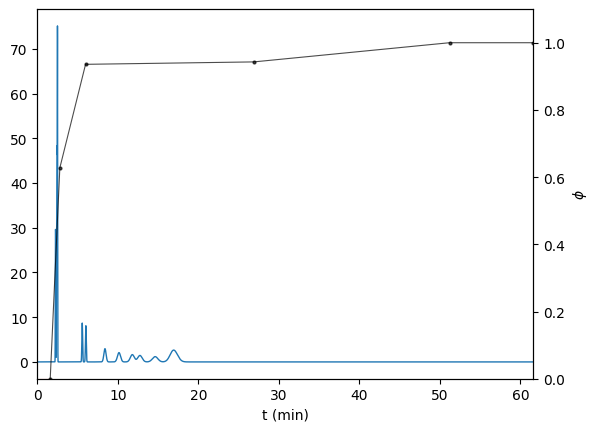

MEASUREMENT MO  4  RES SCORE  7.924185013405867 TIME SCORE 10.53776254758084


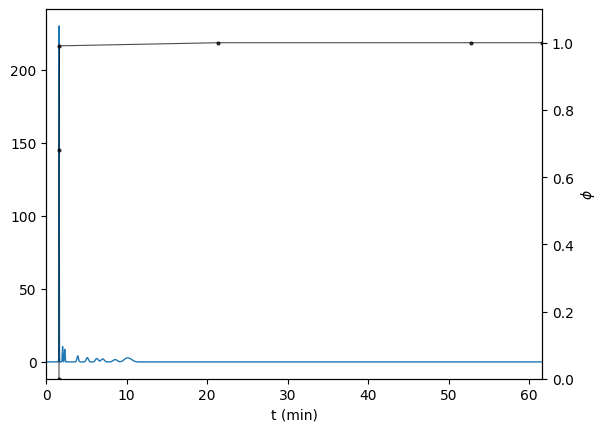

MEASUREMENT MO  5  RES SCORE  7.916525835815181 TIME SCORE 10.141500900476256


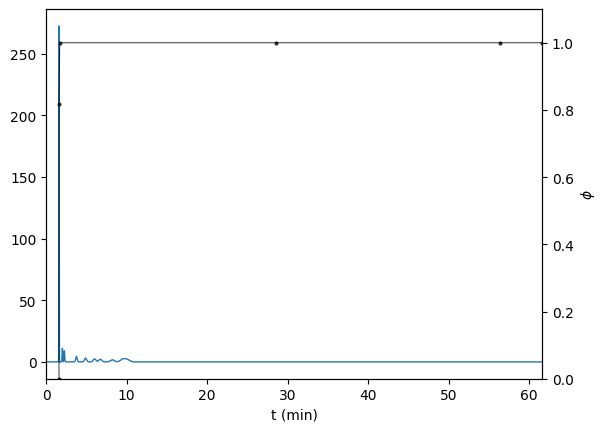

MEASUREMENT MO  6  RES SCORE  7.913900526519309 TIME SCORE 10.114357814397007


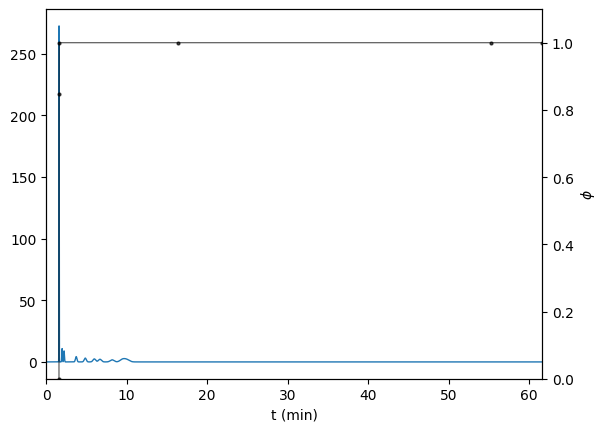

MEASUREMENT MO  7  RES SCORE  12.291427470302056 TIME SCORE 40.2958808845092


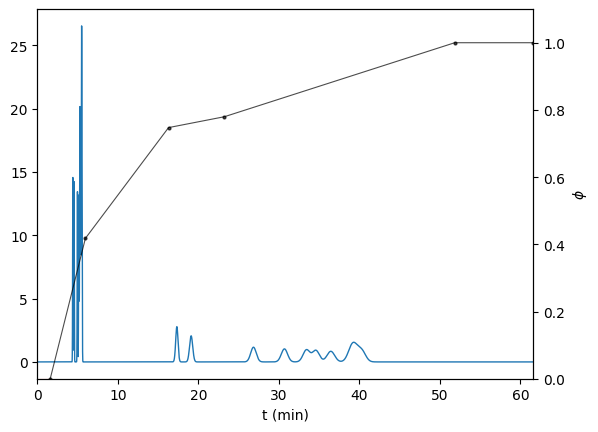

MEASUREMENT MO  8  RES SCORE  7.814914606288644 TIME SCORE 14.584486655562456


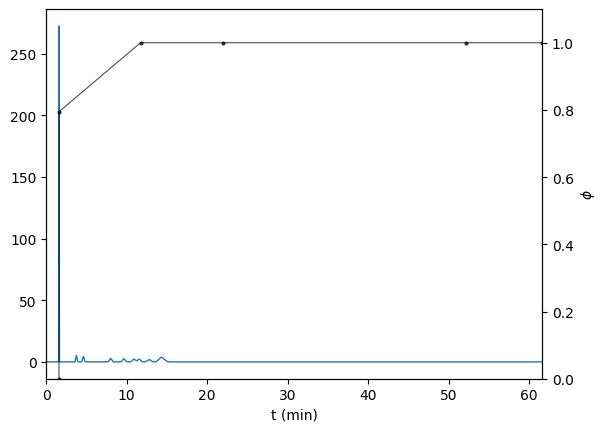

MEASUREMENT MO  9  RES SCORE  11.226493351200165 TIME SCORE 20.22441484020814


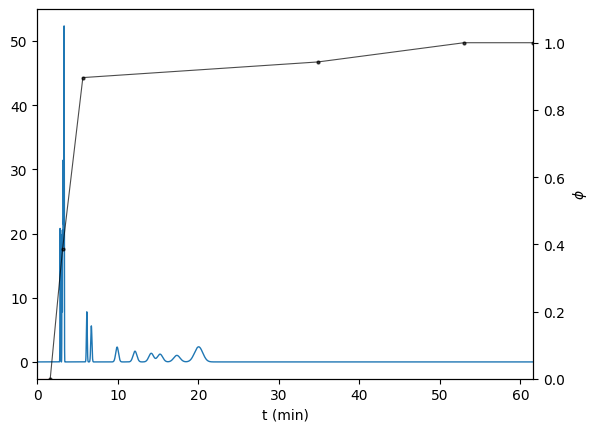

MEASUREMENT MO  10  RES SCORE  8.092197419673598 TIME SCORE 12.168029678545977


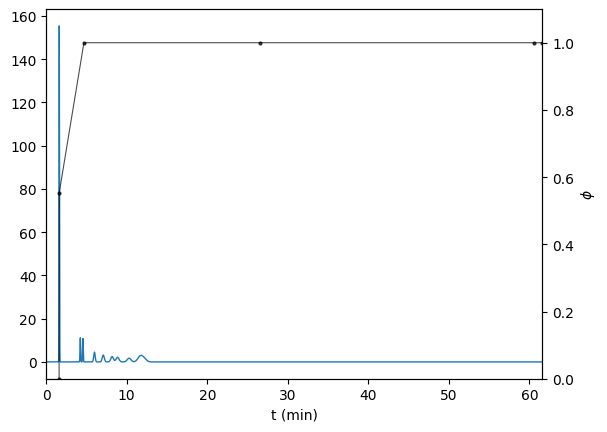

MEASUREMENT MO  11  RES SCORE  9.52389720471387 TIME SCORE 20.423364839077443


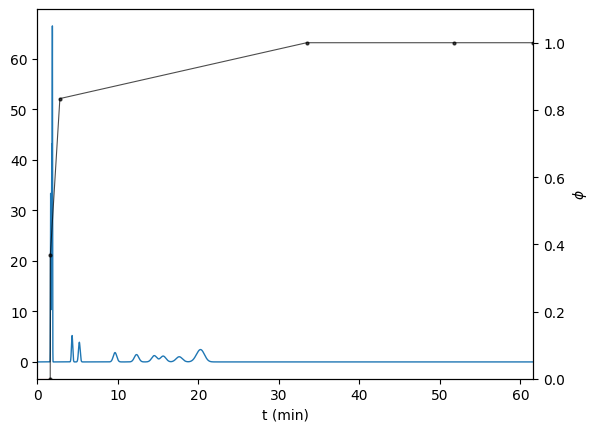

MEASUREMENT MO  12  RES SCORE  10.279187695547499 TIME SCORE 20.010680549812353


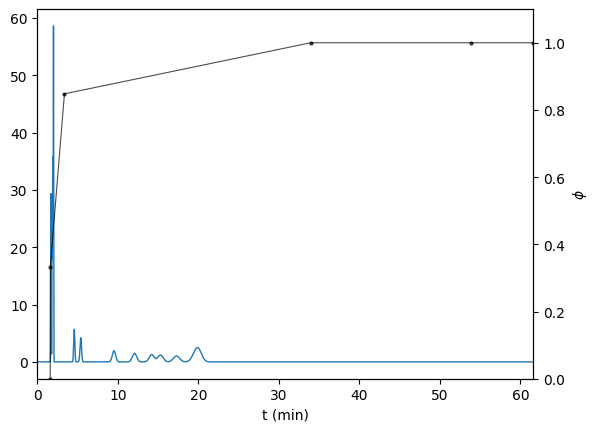

MEASUREMENT MO  13  RES SCORE  11.279002048536476 TIME SCORE 23.611389707222386


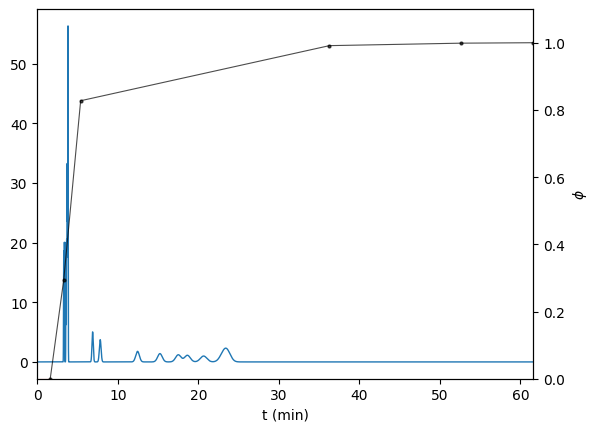

MEASUREMENT MO  14  RES SCORE  11.532876352439837 TIME SCORE 24.39701931332779


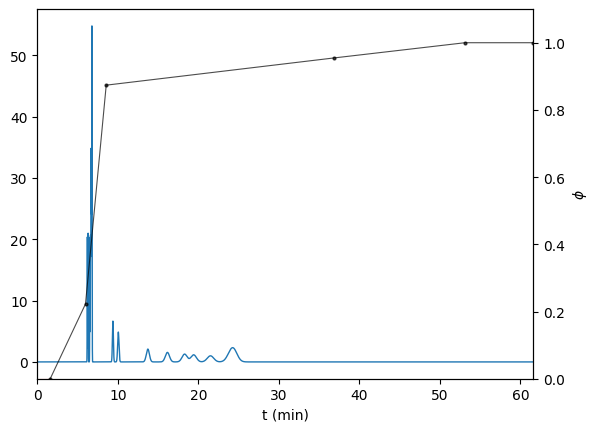

MEASUREMENT MO  15  RES SCORE  11.881841919804165 TIME SCORE 27.6975279433357


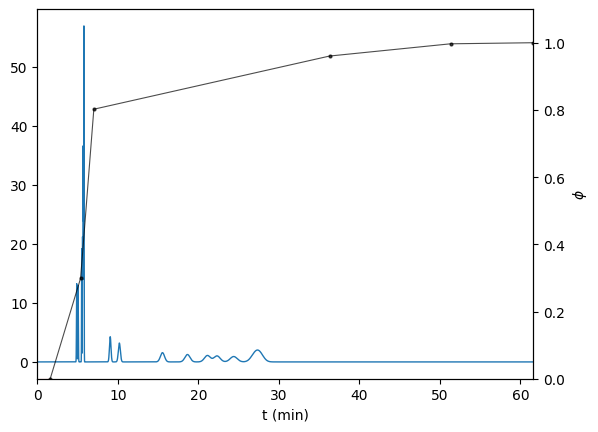

MEASUREMENT MO  16  RES SCORE  10.264196284491579 TIME SCORE 26.594446211623094


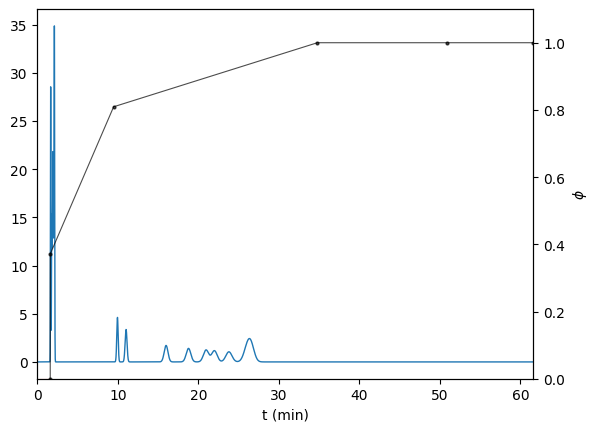

MEASUREMENT MO  17  RES SCORE  7.798689646327685 TIME SCORE 17.14019263654303


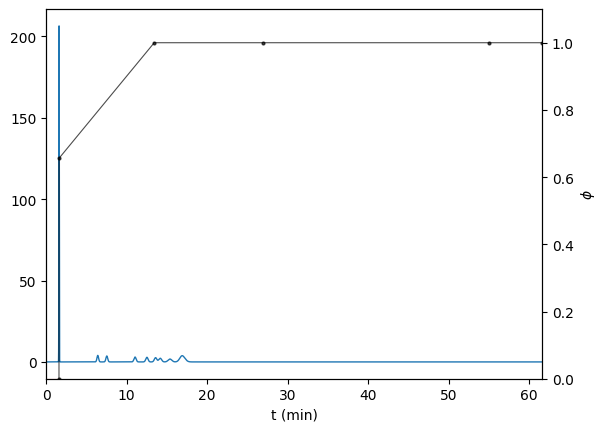

MEASUREMENT MO  18  RES SCORE  7.774734256292562 TIME SCORE 15.663759242412457


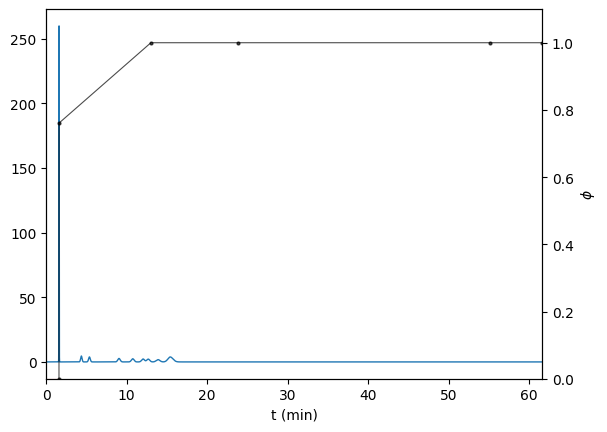

MEASUREMENT MO  19  RES SCORE  7.808236012275329 TIME SCORE 14.949786409200197


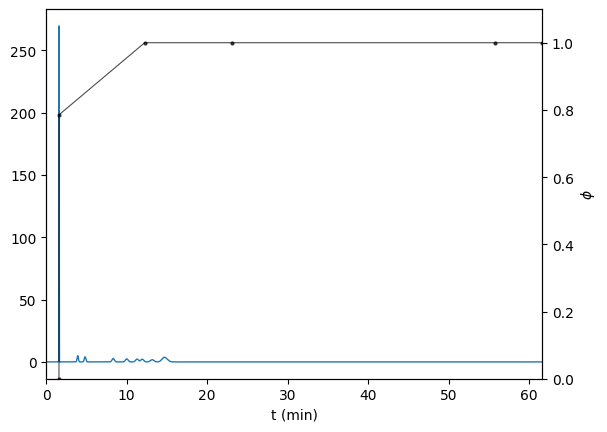

MEASUREMENT MO  20  RES SCORE  7.812255865249988 TIME SCORE 14.698719256396227


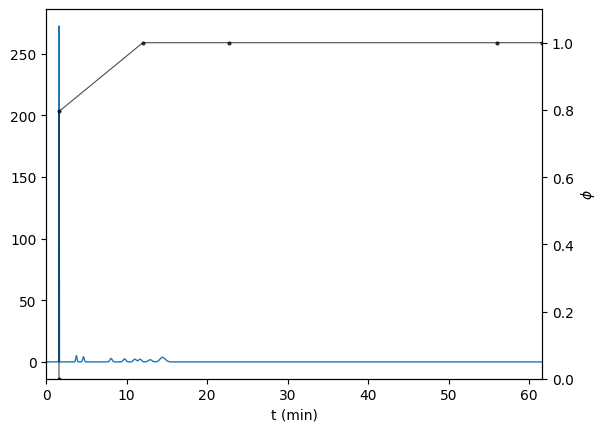

MEASUREMENT MO  21  RES SCORE  7.762641999657698 TIME SCORE 20.46661431155932


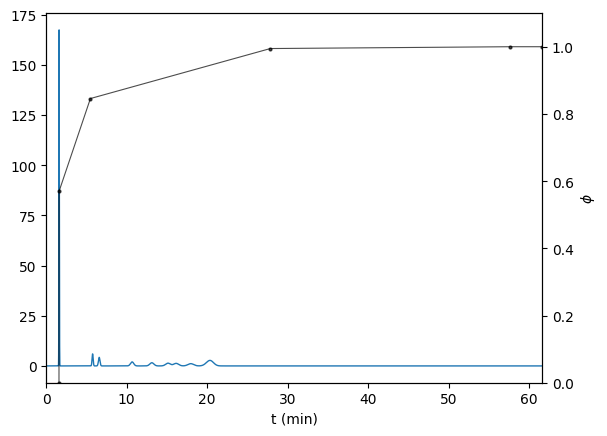

MEASUREMENT MO  22  RES SCORE  7.751578780880374 TIME SCORE 19.446462567969057


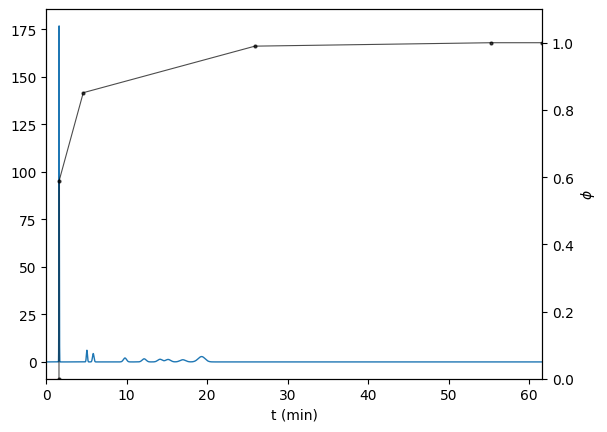

MEASUREMENT MO  23  RES SCORE  7.73682520373222 TIME SCORE 19.14873011383135


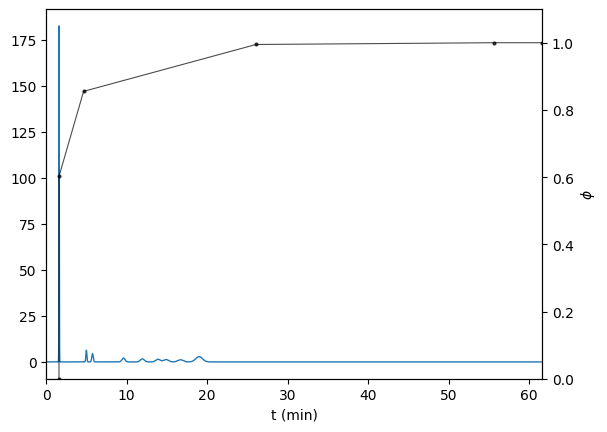

MEASUREMENT MO  24  RES SCORE  7.71304616669679 TIME SCORE 19.6109368381849


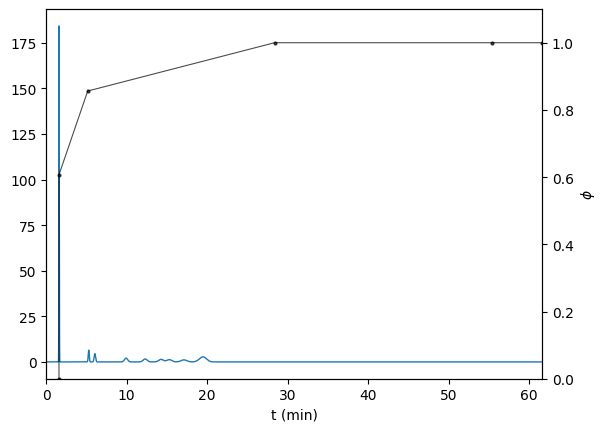

In [13]:
# create some lists to store results in
scores_mo_all = []
seperate_scores_mo_all = []
pars_mo_all = []

ref_point = torch.tensor([0, -60])

# Loop over trials
for trial in range(trials):
    print('Trial ', trial)
    
    # Set random seed for reproducibility
    seed_everything(trial)
    
    # create lists to fill with results per trial
    scores_mo = []
    pars_mo = []
    
    # generate initial experiments
    pars = generate_initial_sorted_data(bounds, n=init_measurements)
    pars_mo = pars
    # convert to parameters that retention modeling code can handle
    phi_list, t_list = bo_to_rm(pars, fixed_phi_pars, fixed_time_pars)
    
    # Perform random initial experiments
    for i in range(len(phi_list)):
        tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[i], t_list[i], N)
        score = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore = -np.max(tR_list)
        
        score_mo = [score, maxtimescore]

        print('INITIAL MEASUREMENT ', i, ' RES SCORE ', score, 'TIME SCORE', -maxtimescore)
        plot_chromatogram(tR_list, W_list, phi_list[i], t_list[i], t_D, t_0, t_init)

        scores_mo.append(score_mo)
    
    # Now we are ready to do BO loop
    for iteration in range(iterations):
        # perform BO round
        new_pars_mo = MOBO_round(bounds, norm_bounds, np.array(scores_mo), pars_mo, ref_point)

        phi_list_mo, t_list_mo = bo_to_rm(new_pars_mo, fixed_phi_pars, fixed_time_pars)

        # perform experiments
        tR_list_mo, W_list_mo = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list_mo[0], 
                                                     t_list_mo[0],N)
        # compute scores
        score_mo = capped_sum_of_resolutions(tR_list_mo, W_list_mo, max_time=60, min_res=0, max_res=1.5) 
        maxtimescore_mo = -np.max(tR_list_mo)


        print('MEASUREMENT MO ', iteration, ' RES SCORE ', score_mo, 'TIME SCORE', -maxtimescore_mo)
        plot_chromatogram(tR_list_mo, W_list_mo, phi_list_mo[0], t_list_mo[0], t_D, t_0, t_init)

        score_mo = [score_mo, maxtimescore_mo]

        # update training data
        # update scores
        scores_mo.append(score_mo)

        # update pars
        pars_mo = np.concatenate((pars_mo, new_pars_mo), axis=0)
    
    # after each trial, append all values to list
    scores_mo_all.append(scores_mo)
    pars_mo_all.append(pars_mo)

## Visualize results

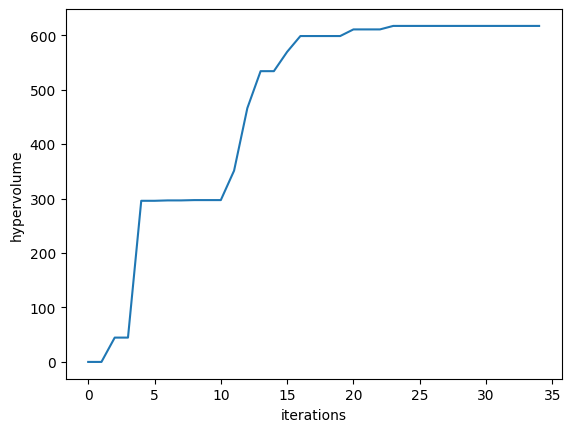

In [14]:
trial_to_observe = 0

# Visualize hypervolume
hvs = hv(np.array(scores_mo_all), ref_point)
plt.plot(hvs[trial_to_observe])
plt.xlabel('iterations')
plt.ylabel('hypervolume')
plt.show()

<IPython.core.display.Javascript object>


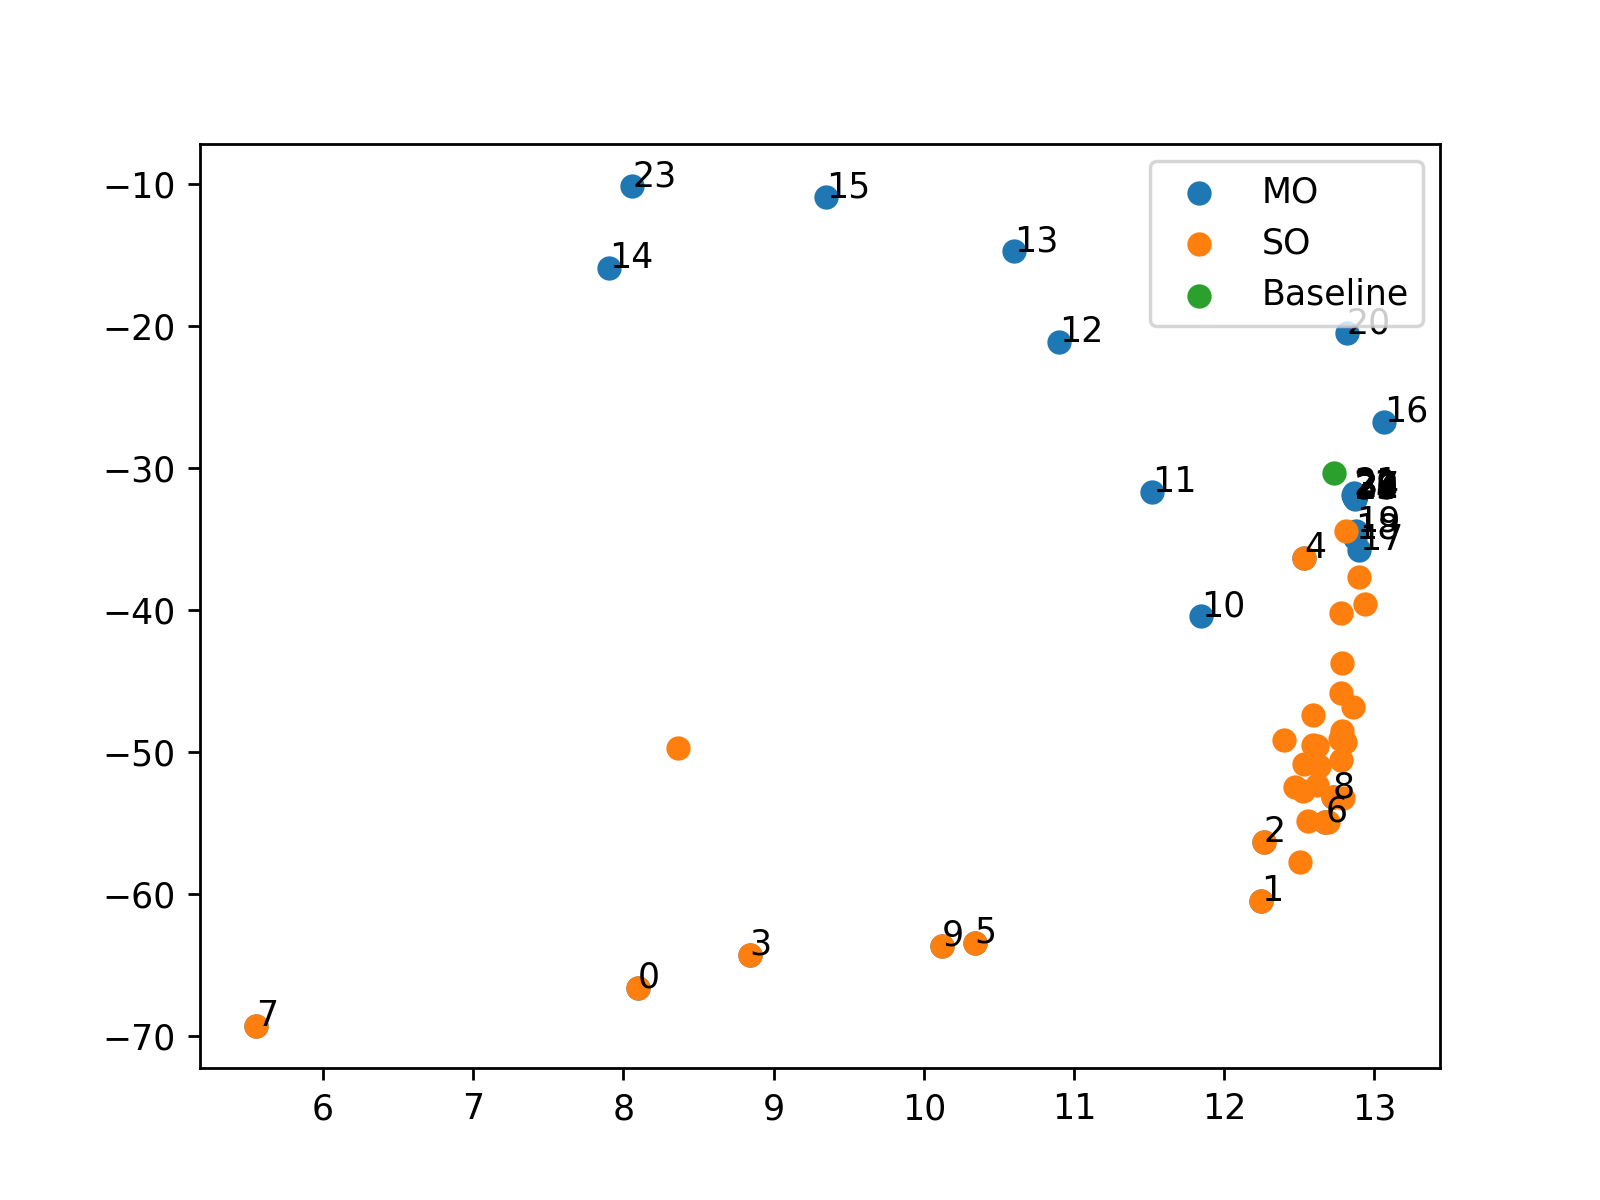

In [15]:
%matplotlib notebook

# Visualize Pareto front
plt.scatter(np.array(scores_mo_all[trial_to_observe])[:,0], np.array(scores_mo_all[trial_to_observe])[:,1], label='MO')

# plot indices
counter = 0
for y in zip(np.array(scores_mo_all[trial_to_observe])[:,0], np.array(scores_mo_all[trial_to_observe])[:,1]):
    plt.text(y[0], y[1], str(counter))
    counter += 1

# plot the single-objective run for comparison
plt.scatter(np.array(seperate_scores_so_all[trial_to_observe])[:,0], 
            np.array(seperate_scores_so_all[trial_to_observe])[:,1], label='SO')

plt.scatter(score_ms, -time_score_ms, label='Baseline')
plt.legend()
plt.show()

Measurement  16


<IPython.core.display.Javascript object>


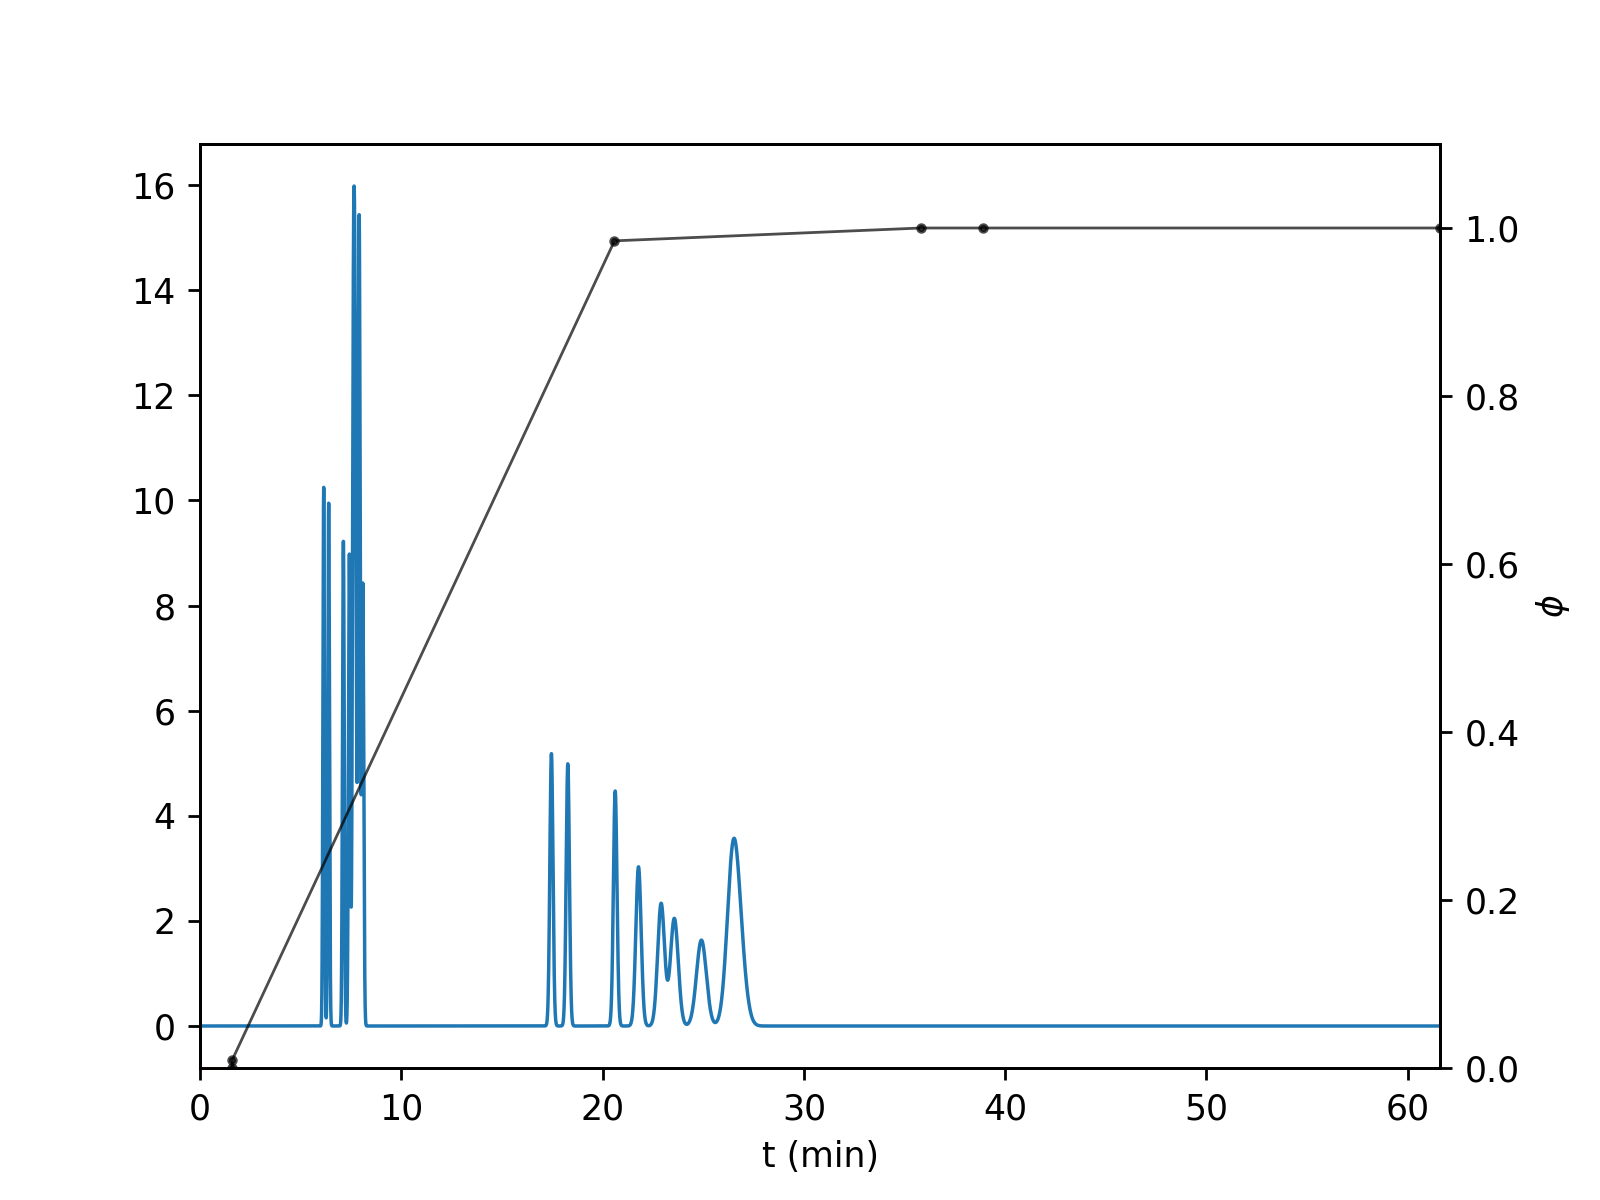

In [16]:
# plot a measurement on the Pareto front (see the numbers in the plot above)
idxloc = 16
best_pars = np.reshape(np.array(pars_mo_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)

Measurement  8


<IPython.core.display.Javascript object>


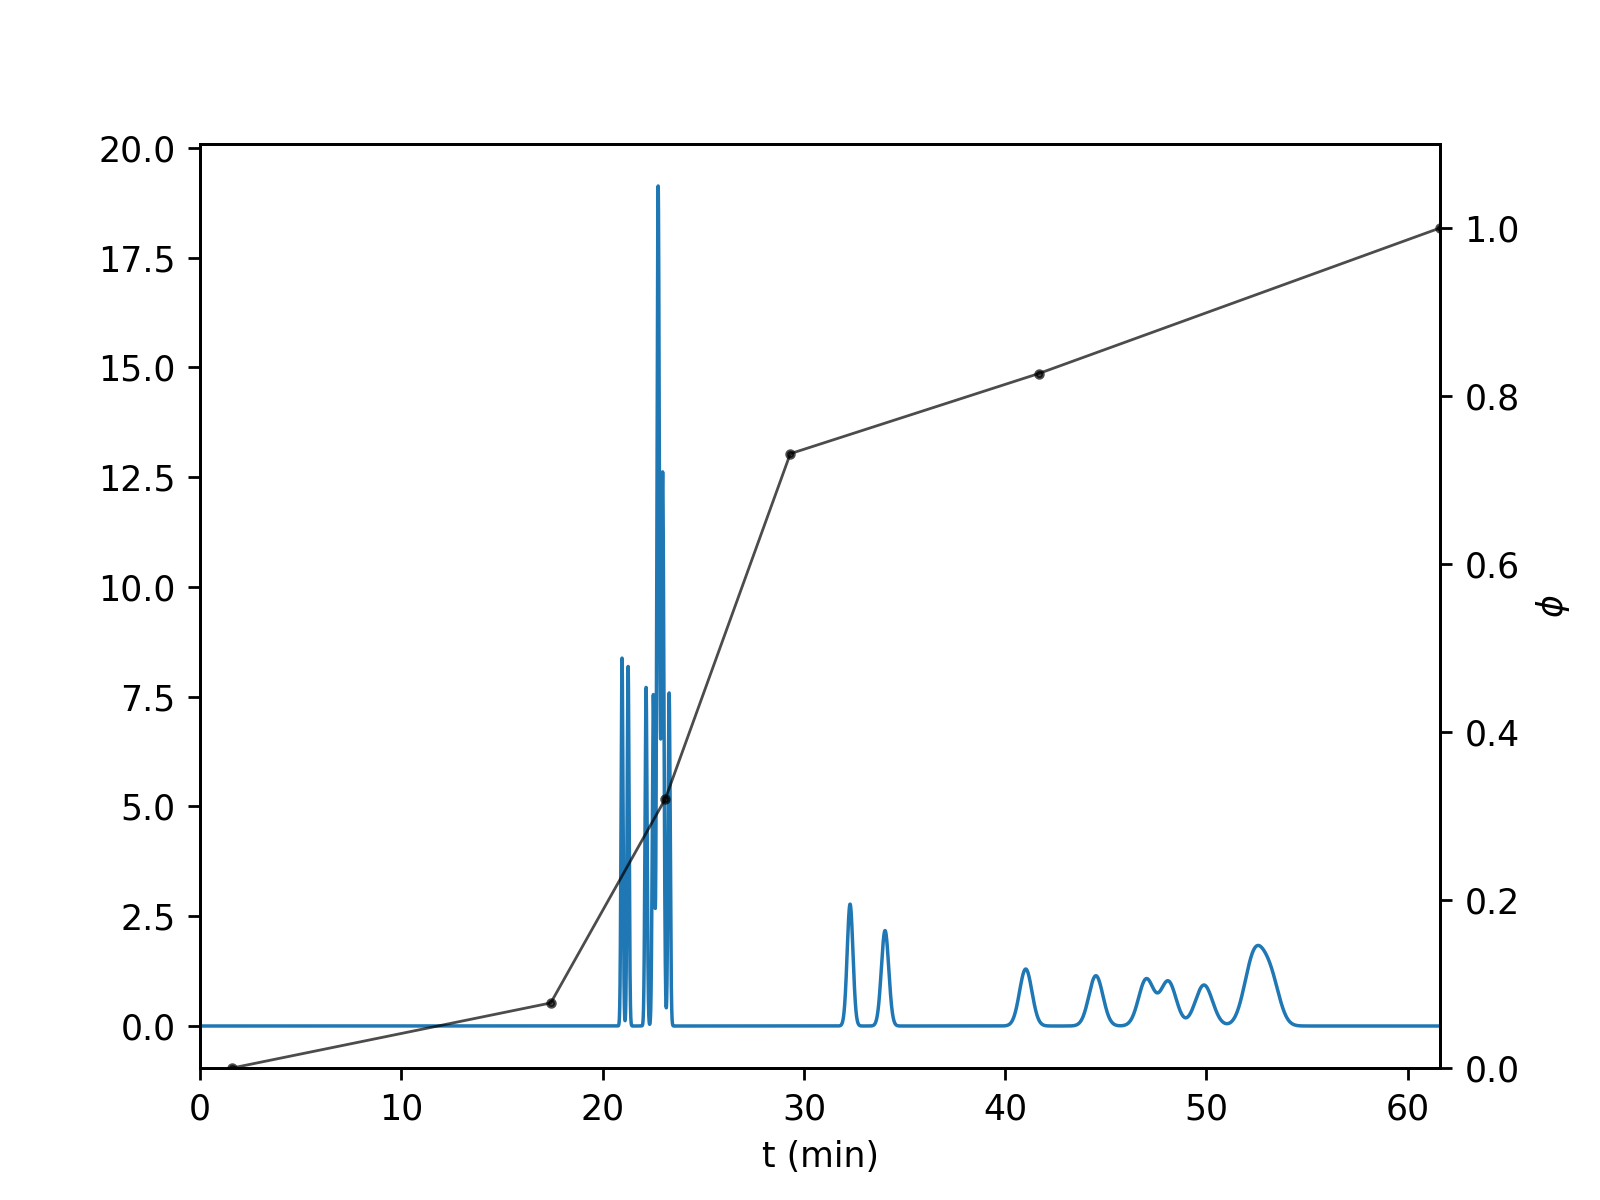

In [17]:
# for SO experiments
idxloc = 8
best_pars = np.reshape(np.array(pars_so_all)[trial_to_observe, idxloc], (1,-1))

phi_list, t_list = bo_to_rm(best_pars, fixed_phi_pars, fixed_time_pars)

# perform experiments
tR_list, W_list = compute_chromatogram(k0_list, S_list, t_0, t_D, t_init, phi_list[0], 
                                             t_list[0],N)
print('Measurement ', idxloc)
plot_chromatogram(tR_list, W_list, phi_list[0], t_list[0], t_D, t_0, t_init)